In [75]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Dataset 1: Diabetes Data
https://www.kaggle.com/uciml/pima-indians-diabetes-database

Algorithms to investigate:
1. Decision trees with some form of pruning
2. Neural networks
3. Boosting
4. Support Vector Machines
5. k-nearest neighbors

In [2]:
# Read data in
df = pd.read_csv("./data/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
X = df.values[:,:-2]
y = df.values[:,-1]
print("Number of positive samples: ", (y==1).sum())
print("Number of positive samples: ", (y==0).sum())
print("y shape: ", y.shape)
print("X shape: ", X.shape)

Number of positive samples:  268
Number of positive samples:  500
y shape:  (768,)
X shape:  (768, 7)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.sum(), y_test.sum()

(213.0, 55.0)

In [342]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_
X_train = scaler.transform(X_train)
X_train.shape, X_train

scaler.fit(X_test)
scaler.mean_
X_test = scaler.transform(X_test)
X_test.shape, X_test

((154, 7),
 array([[ 0.49124165, -0.72667791, -0.44147615, ...,  1.0519189 ,
          0.23374785, -0.17094071],
        [-0.63368347, -0.28534901,  0.31890843, ..., -0.66022144,
          0.43537945, -1.08608042],
        [-0.63368347, -0.41144298, -0.17310512, ..., -0.66022144,
         -0.14579397, -1.05362866],
        ...,
        [ 1.05370422, -0.82124838,  0.18472291, ..., -0.66022144,
          0.56584695,  0.00754398],
        [-0.63368347,  0.78644972,  0.09526591, ...,  2.58383394,
         -0.47789306, -0.47274211],
        [ 1.05370422, -1.48324172,  0.09526591, ..., -0.21866946,
          0.38793672,  0.72148276]]))

### 1.1 Decision Tree with some form of pruning

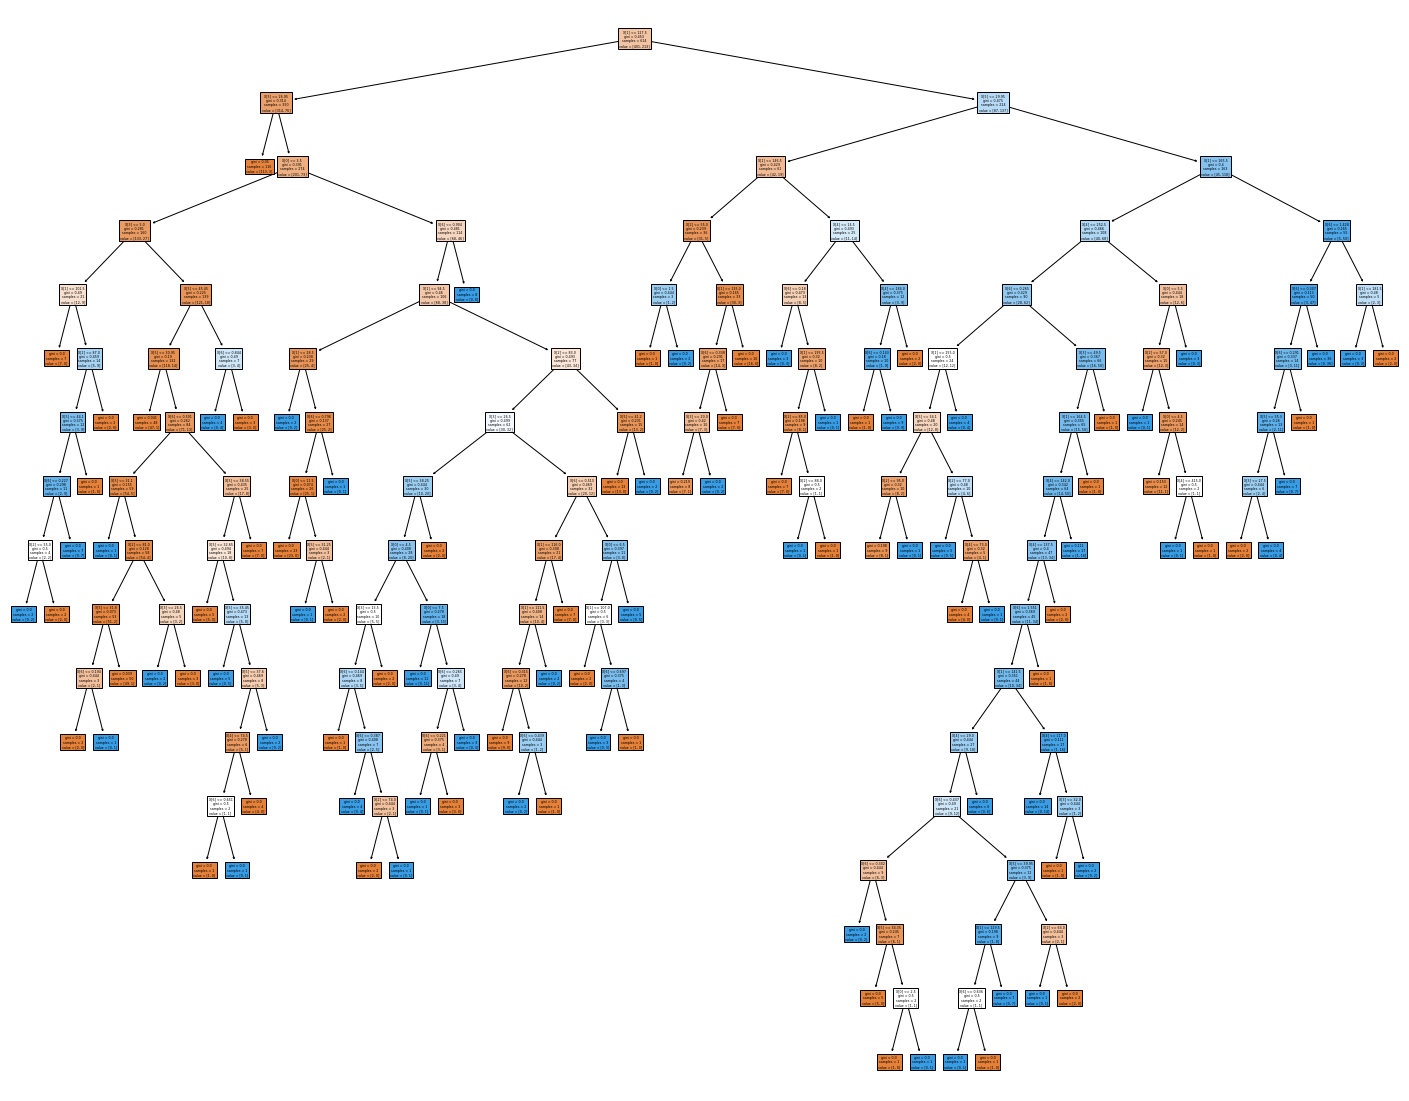

In [37]:
clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=100)
clf.fit(X_train, y_train)
plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, filled=True)
plt.show()

[Text(0.5, 0, 'Depth of Tree'), Text(0, 0.5, 'AUC')]

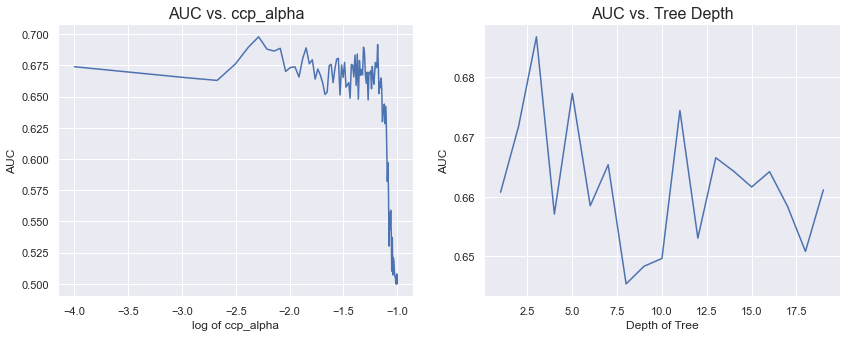

In [44]:
sns.set_theme()


n = 20

ccp_alphas = np.linspace(0.0001, 0.1, 100)
scores = []
for ccp_alpha in ccp_alphas:
    avg = 0
    for i in range(n):
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_tr, y_tr)
        avg += roc_auc_score(y_val, clf.predict(X_val))
    avg /= n
    scores.append(avg)

f, ax = plt.subplots(1,2, figsize=(14, 5))
sns.lineplot(x=np.log10(np.array(ccp_alphas)), y=np.array(scores), ax=ax[0])
ax[0].set_title("AUC vs. ccp_alpha", fontsize=16)
ax[0].set(xlabel='log of ccp_alpha', ylabel='AUC')


opts = range(1,20)
scores = []
for opt in opts:
    avg = 0
    for i in range(n):
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2)
        clf = DecisionTreeClassifier(random_state=0, max_depth=opt)
        clf.fit(X_tr, y_tr)
        avg += roc_auc_score(y_val, clf.predict(X_val))
    avg /= n
    scores.append(avg)
        

sns.lineplot(x=np.array(opts), y=np.array(scores), markers=True, ax=ax[1])
ax[1].set_title("AUC vs. Tree Depth", fontsize=16)
ax[1].set(xlabel='Depth of Tree', ylabel='AUC')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

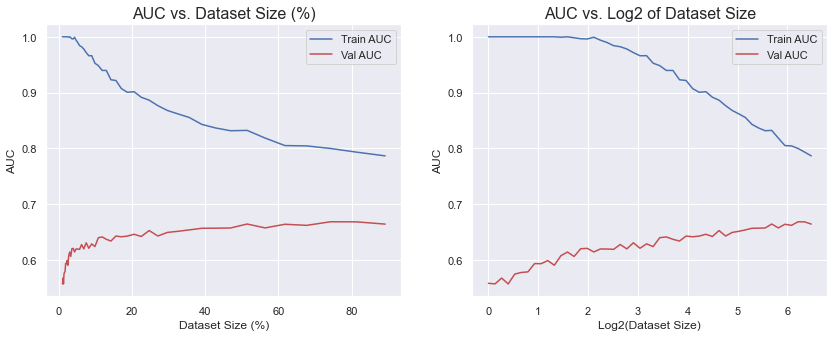

In [169]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 100
scores_tr = []
scores_val = []
for train_sz in tqdm(train_szs):
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
        clf = DecisionTreeClassifier(random_state=0, max_depth=5)
        clf.fit(X_train1, y_train1)
        score = roc_auc_score(y_test1, clf.predict(X_test1))
        avg_score_val += score
        score = roc_auc_score(y_train1, clf.predict(X_train1))
        avg_score_tr += score
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    scores_val.append(avg_score_val)

f, ax = plt.subplots(1,2, figsize=(14, 5))

ax[0].plot(np.array(train_szs)*100, scores_tr, '-', color="b", label="Train AUC")
ax[0].plot(np.array(train_szs)*100, scores_val, '-', color="r", label="Val AUC")
ax[0].legend()
ax[0].set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax[0].set(xlabel='Dataset Size (%)', ylabel='AUC')

ax[1].plot(np.log2(np.array(train_szs)*100), scores_tr, '-', color="b", label="Train AUC")
ax[1].plot(np.log2(np.array(train_szs)*100), scores_val, '-', color="r", label="Val AUC")
ax[1].legend()
ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')


# sns.scatterplot(x='Train Size (%)', y='AUC', \
#            data=pd.DataFrame({'Train Size (%)':np.array(train_szs)*100, 'AUC':np.array(scores)}))

In [343]:
# Finding final train and test scores
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Test:  0.7101010101010101
Train:  0.7937257794480934


### 1.2 Neural Network

In [178]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        minority_mask = y == 1
        minority_idxs = np.argwhere(minority_mask)[:,0]
        minority_idxs_sampled = np.random.choice(minority_idxs, size=int(y.shape[0]/3), replace=True)
        self.X = np.concatenate([X, X[minority_idxs_sampled]])
        self.y = np.concatenate([y, y[minority_idxs_sampled]]).reshape((-1,1))
        print("# of positive examples: {}, # of negative examples: {}".format((self.y==1).sum(),(self.y==0).sum()))
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.squeeze(torch.from_numpy(self.y[idx]).long(), 0)

class MiniNet(torch.nn.Module):
    def __init__(self, h1):
        super(MiniNet, self).__init__()
        h2 = 50
        self.fc1 = torch.nn.Linear(7, h1)
#         self.fc2 = torch.nn.Linear(h1, h2)
        self.fc3 = torch.nn.Linear(h1, 2)
        
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.2)
                
    def forward(self, x):
        x = self.fc1(x)
#         x = self.relu(x)
#         x = self.drop(x)
#         x = self.fc2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [191]:
def training_loop(h, lr, X_tr, X_val, y_tr, y_val, use_early_stopping=True):
#     print("Running training with h: {} and lr: {}".format(h, lr))
    net = MiniNet(h)
    net = net.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    batch_size = 64
    early = 10
    auc_avg = 0
    epochs = 300
    best_net = copy.deepcopy(net)
    verbose_train = False

    dataset_train = MyDataset(X_tr, y_tr)

    best = 0
    aucs = []

    for j, epoch in tqdm(enumerate(range(epochs))):
        loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
        net = net.train()
        for i, (X_batch, y_batch) in enumerate(iter(loader_train)):
            optimizer.zero_grad()
            output = net(X_batch)
            
            loss = criterion(output, y_batch)
            # Changing loss weighting
            # weights = torch.ones(loss.size())
            # weightsLarge = torch.ones(loss.size()) * 10000
            # weights = torch.where(y_batch==0, weights, weightsLarge)
            # loss = weights * loss
            loss = loss.mean()
            
            loss.backward()
            optimizer.step()
            
        # Run on training
        net = net.eval()
        outputs = net(torch.from_numpy(X_tr).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc_tr = roc_auc_score(y_tr, yhat.detach())

        # Run on validation
        net = net.eval()
        outputs = net(torch.from_numpy(X_val).float())
        yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
        auc = roc_auc_score(y_val, yhat.detach())

        if use_early_stopping:
            if auc > best:
                best = auc
                early_cnt = 0
                best_net = copy.deepcopy(net)
            elif early_cnt >= early:
                if verbose_train: print("Early Stopping, best AUC was {}".format(best))
                auc_avg+=best
                break
            else:
                early_cnt += 1

        # Check if end
        if epoch==epochs-1:
            if verbose_train: print("Finished epochs, best AUC was {}".format(best))
            auc_avg+=best
            break
            
        aucs.append([j, auc_tr, auc])

        if verbose_train: print("Batch {}, Validation AUC: {}".format(epoch, auc))
    return best_net, aucs

# Predict on val set
from sklearn.metrics import accuracy_score
def evaluate(net, X_test, y_test):
    net = net.eval()
    outputs = net(torch.from_numpy(X_test).float())
    yhat = torch.nn.functional.softmax(outputs, dim=1)[:,1]
    yhat = yhat.detach().numpy()
    auc = roc_auc_score(y_test, yhat)
    t = 0.5
    yhat[yhat>t] = 1
    yhat[yhat<=t] = 0
    return auc, accuracy_score(y_test, yhat)

In [ ]:
hs = [10,20,40,80,160,320,640,1280, 2560]
f1s0 = []
aucs0 = []
accs0 = []
n_folds = 5
n_loops = 5

skf = StratifiedKFold(n_splits=n_folds)

for h in hs:
    avg_auc = 0
    avg_acc = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            print("new training")
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            data = [X_tr, X_val, y_tr, y_val]
            net, _ = training_loop(h, 0.001, *data)
            auc, acc = evaluate(net, X_test=X_val, y_test=y_val)
            print(auc)
            avg_auc += auc
            avg_acc += acc
    avg_auc /= (n_loops*n_folds)
    avg_acc /= (n_loops*n_folds)
    f1s0.append(avg_f1)
    aucs0.append(avg_auc)
    accs0.append(avg_acc)

In [346]:
# LR Grid Search
lrs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]
aucs1 = []
accs1 = []
n_folds = 5
n_loops = 5

for lr in lrs:
    avg_auc = 0
    avg_acc = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            print("new training")
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            data = [X_tr, X_val, y_tr, y_val]
            net, _ = training_loop(h, 0.001, *data)
            auc, acc = evaluate(net, X_test=X_val, y_test=y_val)
            avg_auc += auc
            avg_acc += acc
    avg_auc /= (n_loops*n_folds)
    avg_acc /= (n_loops*n_folds)
    aucs1.append(avg_auc)
    accs1.append(avg_acc)

3it [00:00, 29.78it/s]

new training
# of positive examples: 369, # of negative examples: 367


18it [00:00, 32.52it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 381, # of negative examples: 355


42it [00:01, 35.51it/s]
4it [00:00, 36.13it/s]

new training
# of positive examples: 374, # of negative examples: 362


26it [00:00, 35.12it/s]
4it [00:00, 37.83it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 33.73it/s]
4it [00:00, 36.38it/s]

new training
# of positive examples: 373, # of negative examples: 364


22it [00:00, 35.08it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 374, # of negative examples: 363


23it [00:00, 35.15it/s]
4it [00:00, 36.78it/s]

new training
# of positive examples: 374, # of negative examples: 363


48it [00:01, 35.68it/s]
4it [00:00, 35.97it/s]

new training
# of positive examples: 382, # of negative examples: 355


48it [00:01, 35.59it/s]
8it [00:00, 37.34it/s]

new training
# of positive examples: 381, # of negative examples: 356


78it [00:02, 36.47it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 380, # of negative examples: 357


12it [00:00, 33.70it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 369, # of negative examples: 367


17it [00:00, 34.14it/s]
4it [00:00, 35.49it/s]

new training
# of positive examples: 381, # of negative examples: 355


35it [00:00, 35.68it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 374, # of negative examples: 362


14it [00:00, 33.99it/s]
4it [00:00, 37.19it/s]

new training
# of positive examples: 369, # of negative examples: 367


46it [00:01, 34.97it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 373, # of negative examples: 364


11it [00:00, 32.92it/s]
4it [00:00, 36.13it/s]

new training
# of positive examples: 374, # of negative examples: 363


63it [00:01, 36.48it/s]
4it [00:00, 36.37it/s]

new training
# of positive examples: 374, # of negative examples: 363


63it [00:01, 36.39it/s]
4it [00:00, 36.69it/s]

new training
# of positive examples: 382, # of negative examples: 355


20it [00:00, 33.31it/s]
4it [00:00, 37.84it/s]

new training
# of positive examples: 381, # of negative examples: 356


57it [00:01, 35.81it/s]
4it [00:00, 36.26it/s]

new training
# of positive examples: 380, # of negative examples: 357


78it [00:02, 36.16it/s]
4it [00:00, 36.07it/s]

new training
# of positive examples: 369, # of negative examples: 367


13it [00:00, 33.93it/s]
4it [00:00, 37.41it/s]

new training
# of positive examples: 381, # of negative examples: 355


16it [00:00, 34.62it/s]
4it [00:00, 37.48it/s]

new training
# of positive examples: 374, # of negative examples: 362


57it [00:01, 35.37it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 369, # of negative examples: 367


24it [00:00, 34.11it/s]
4it [00:00, 33.98it/s]

new training
# of positive examples: 373, # of negative examples: 364


22it [00:00, 34.60it/s]
4it [00:00, 35.80it/s]

new training
# of positive examples: 374, # of negative examples: 363


19it [00:00, 33.18it/s]
4it [00:00, 36.03it/s]

new training
# of positive examples: 374, # of negative examples: 363


46it [00:01, 35.43it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 382, # of negative examples: 355


41it [00:01, 34.82it/s]
4it [00:00, 37.14it/s]

new training
# of positive examples: 381, # of negative examples: 356


11it [00:00, 33.72it/s]
4it [00:00, 33.70it/s]

new training
# of positive examples: 380, # of negative examples: 357


36it [00:01, 34.32it/s]
4it [00:00, 37.74it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 33.55it/s]
4it [00:00, 36.46it/s]

new training
# of positive examples: 381, # of negative examples: 355


51it [00:01, 35.01it/s]
4it [00:00, 34.27it/s]

new training
# of positive examples: 374, # of negative examples: 362


24it [00:00, 33.94it/s]
4it [00:00, 35.71it/s]

new training
# of positive examples: 369, # of negative examples: 367


29it [00:00, 32.07it/s]
4it [00:00, 35.32it/s]

new training
# of positive examples: 373, # of negative examples: 364


16it [00:00, 31.92it/s]
4it [00:00, 32.60it/s]

new training
# of positive examples: 374, # of negative examples: 363


30it [00:00, 34.57it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 374, # of negative examples: 363


44it [00:01, 34.96it/s]
4it [00:00, 35.48it/s]

new training
# of positive examples: 382, # of negative examples: 355


35it [00:01, 33.74it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 381, # of negative examples: 356


13it [00:00, 34.12it/s]
8it [00:00, 37.69it/s]

new training
# of positive examples: 380, # of negative examples: 357


17it [00:00, 34.83it/s]
4it [00:00, 37.84it/s]

new training
# of positive examples: 369, # of negative examples: 367


12it [00:00, 34.30it/s]
4it [00:00, 37.22it/s]

new training
# of positive examples: 381, # of negative examples: 355


11it [00:00, 34.07it/s]
4it [00:00, 36.45it/s]

new training
# of positive examples: 374, # of negative examples: 362


61it [00:01, 36.24it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 34.04it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 373, # of negative examples: 364


19it [00:00, 35.02it/s]
4it [00:00, 37.08it/s]

new training
# of positive examples: 374, # of negative examples: 363


70it [00:01, 36.34it/s]
4it [00:00, 37.48it/s]

new training
# of positive examples: 374, # of negative examples: 363


23it [00:00, 35.74it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 382, # of negative examples: 355


17it [00:00, 34.93it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 381, # of negative examples: 356


19it [00:00, 34.97it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 380, # of negative examples: 357


15it [00:00, 34.60it/s]
4it [00:00, 36.09it/s]

new training
# of positive examples: 369, # of negative examples: 367


23it [00:00, 34.96it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 381, # of negative examples: 355


30it [00:00, 35.98it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 374, # of negative examples: 362


11it [00:00, 33.93it/s]
4it [00:00, 37.26it/s]

new training
# of positive examples: 369, # of negative examples: 367


23it [00:00, 35.35it/s]
4it [00:00, 36.46it/s]

new training
# of positive examples: 373, # of negative examples: 364


33it [00:00, 35.54it/s]
4it [00:00, 36.27it/s]

new training
# of positive examples: 374, # of negative examples: 363


15it [00:00, 34.44it/s]
4it [00:00, 36.67it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 33.90it/s]
8it [00:00, 37.45it/s]

new training
# of positive examples: 382, # of negative examples: 355


28it [00:00, 35.63it/s]
4it [00:00, 37.16it/s]

new training
# of positive examples: 381, # of negative examples: 356


74it [00:02, 36.52it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 380, # of negative examples: 357


26it [00:00, 35.76it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 369, # of negative examples: 367


30it [00:00, 36.02it/s]
4it [00:00, 37.22it/s]

new training
# of positive examples: 381, # of negative examples: 355


11it [00:00, 33.76it/s]
4it [00:00, 37.48it/s]

new training
# of positive examples: 374, # of negative examples: 362


41it [00:01, 35.94it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 369, # of negative examples: 367


29it [00:00, 35.37it/s]
4it [00:00, 36.79it/s]

new training
# of positive examples: 373, # of negative examples: 364


54it [00:01, 36.32it/s]
4it [00:00, 35.81it/s]

new training
# of positive examples: 374, # of negative examples: 363


12it [00:00, 33.17it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 374, # of negative examples: 363


36it [00:00, 36.12it/s]
4it [00:00, 37.17it/s]

new training
# of positive examples: 382, # of negative examples: 355


22it [00:00, 35.33it/s]
4it [00:00, 36.80it/s]

new training
# of positive examples: 381, # of negative examples: 356


18it [00:00, 34.77it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 380, # of negative examples: 357


16it [00:00, 34.54it/s]
4it [00:00, 35.17it/s]

new training
# of positive examples: 369, # of negative examples: 367


14it [00:00, 31.47it/s]
4it [00:00, 36.13it/s]

new training
# of positive examples: 381, # of negative examples: 355


13it [00:00, 31.49it/s]
4it [00:00, 37.13it/s]

new training
# of positive examples: 374, # of negative examples: 362


14it [00:00, 33.88it/s]
4it [00:00, 37.45it/s]

new training
# of positive examples: 369, # of negative examples: 367


16it [00:00, 34.59it/s]
4it [00:00, 37.65it/s]

new training
# of positive examples: 373, # of negative examples: 364


34it [00:00, 34.93it/s]
4it [00:00, 37.47it/s]

new training
# of positive examples: 374, # of negative examples: 363


28it [00:00, 35.45it/s]
4it [00:00, 37.11it/s]

new training
# of positive examples: 374, # of negative examples: 363


46it [00:01, 36.31it/s]
4it [00:00, 37.83it/s]

new training
# of positive examples: 382, # of negative examples: 355


43it [00:01, 34.14it/s]
4it [00:00, 35.73it/s]

new training
# of positive examples: 381, # of negative examples: 356


33it [00:00, 35.49it/s]
4it [00:00, 36.46it/s]

new training
# of positive examples: 380, # of negative examples: 357


68it [00:01, 36.39it/s]
4it [00:00, 36.77it/s]

new training
# of positive examples: 369, # of negative examples: 367


47it [00:01, 31.84it/s]
4it [00:00, 35.48it/s]

new training
# of positive examples: 381, # of negative examples: 355


23it [00:00, 33.20it/s]
4it [00:00, 35.81it/s]

new training
# of positive examples: 374, # of negative examples: 362


66it [00:01, 33.61it/s]
4it [00:00, 30.61it/s]

new training
# of positive examples: 369, # of negative examples: 367


50it [00:01, 31.67it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 373, # of negative examples: 364


26it [00:00, 31.41it/s]
4it [00:00, 31.33it/s]

new training
# of positive examples: 374, # of negative examples: 363


75it [00:02, 33.42it/s]
4it [00:00, 35.18it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 32.21it/s]
4it [00:00, 33.00it/s]

new training
# of positive examples: 382, # of negative examples: 355


11it [00:00, 30.13it/s]
4it [00:00, 33.69it/s]

new training
# of positive examples: 381, # of negative examples: 356


11it [00:00, 29.02it/s]
4it [00:00, 30.61it/s]

new training
# of positive examples: 380, # of negative examples: 357


28it [00:00, 31.39it/s]
4it [00:00, 33.14it/s]

new training
# of positive examples: 369, # of negative examples: 367


13it [00:00, 30.80it/s]
4it [00:00, 33.62it/s]

new training
# of positive examples: 381, # of negative examples: 355


11it [00:00, 30.84it/s]
4it [00:00, 33.58it/s]

new training
# of positive examples: 374, # of negative examples: 362


12it [00:00, 31.08it/s]
4it [00:00, 33.14it/s]

new training
# of positive examples: 369, # of negative examples: 367


56it [00:01, 32.24it/s]
4it [00:00, 32.10it/s]

new training
# of positive examples: 373, # of negative examples: 364


25it [00:00, 31.00it/s]
4it [00:00, 31.82it/s]

new training
# of positive examples: 374, # of negative examples: 363


56it [00:01, 31.67it/s]
4it [00:00, 32.16it/s]

new training
# of positive examples: 374, # of negative examples: 363


15it [00:00, 30.10it/s]
4it [00:00, 31.73it/s]

new training
# of positive examples: 382, # of negative examples: 355


16it [00:00, 28.52it/s]
3it [00:00, 29.78it/s]

new training
# of positive examples: 381, # of negative examples: 356


42it [00:01, 31.25it/s]
4it [00:00, 33.41it/s]

new training
# of positive examples: 380, # of negative examples: 357


30it [00:00, 32.69it/s]
4it [00:00, 33.41it/s]

new training
# of positive examples: 369, # of negative examples: 367


22it [00:00, 32.15it/s]
4it [00:00, 32.87it/s]

new training
# of positive examples: 381, # of negative examples: 355


32it [00:00, 32.05it/s]
4it [00:00, 33.15it/s]

new training
# of positive examples: 374, # of negative examples: 362


21it [00:00, 30.79it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 369, # of negative examples: 367


37it [00:01, 31.95it/s]
4it [00:00, 32.61it/s]

new training
# of positive examples: 373, # of negative examples: 364


20it [00:00, 30.71it/s]
4it [00:00, 31.33it/s]

new training
# of positive examples: 374, # of negative examples: 363


38it [00:01, 31.24it/s]
4it [00:00, 33.41it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 30.38it/s]
4it [00:00, 30.84it/s]

new training
# of positive examples: 382, # of negative examples: 355


38it [00:01, 30.86it/s]
4it [00:00, 30.79it/s]

new training
# of positive examples: 381, # of negative examples: 356


17it [00:00, 29.28it/s]
4it [00:00, 32.08it/s]

new training
# of positive examples: 380, # of negative examples: 357


15it [00:00, 30.58it/s]
4it [00:00, 32.76it/s]

new training
# of positive examples: 369, # of negative examples: 367


36it [00:01, 30.76it/s]
4it [00:00, 33.47it/s]

new training
# of positive examples: 381, # of negative examples: 355


15it [00:00, 30.32it/s]
4it [00:00, 32.44it/s]

new training
# of positive examples: 374, # of negative examples: 362


47it [00:01, 31.71it/s]
4it [00:00, 32.45it/s]

new training
# of positive examples: 369, # of negative examples: 367


24it [00:00, 30.82it/s]
4it [00:00, 31.49it/s]

new training
# of positive examples: 373, # of negative examples: 364


23it [00:00, 31.26it/s]
4it [00:00, 33.28it/s]

new training
# of positive examples: 374, # of negative examples: 363


62it [00:02, 29.40it/s]
4it [00:00, 30.57it/s]

new training
# of positive examples: 374, # of negative examples: 363


39it [00:01, 31.30it/s]
4it [00:00, 31.76it/s]

new training
# of positive examples: 382, # of negative examples: 355


62it [00:01, 31.21it/s]
4it [00:00, 31.08it/s]

new training
# of positive examples: 381, # of negative examples: 356


13it [00:00, 28.27it/s]
4it [00:00, 31.08it/s]

new training
# of positive examples: 380, # of negative examples: 357


79it [00:02, 30.58it/s]
3it [00:00, 27.35it/s]

new training
# of positive examples: 369, # of negative examples: 367


38it [00:01, 29.36it/s]
4it [00:00, 31.21it/s]

new training
# of positive examples: 381, # of negative examples: 355


12it [00:00, 28.64it/s]
4it [00:00, 30.81it/s]

new training
# of positive examples: 374, # of negative examples: 362


13it [00:00, 29.15it/s]
4it [00:00, 31.82it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 28.79it/s]
4it [00:00, 32.87it/s]

new training
# of positive examples: 373, # of negative examples: 364


24it [00:00, 31.17it/s]
4it [00:00, 32.01it/s]

new training
# of positive examples: 374, # of negative examples: 363


35it [00:01, 31.58it/s]
4it [00:00, 31.77it/s]

new training
# of positive examples: 374, # of negative examples: 363


34it [00:01, 31.75it/s]
4it [00:00, 31.38it/s]

new training
# of positive examples: 382, # of negative examples: 355


39it [00:01, 31.62it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 381, # of negative examples: 356


36it [00:01, 31.50it/s]
4it [00:00, 32.87it/s]

new training
# of positive examples: 380, # of negative examples: 357


11it [00:00, 28.52it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 369, # of negative examples: 367


55it [00:01, 31.83it/s]
4it [00:00, 32.33it/s]

new training
# of positive examples: 381, # of negative examples: 355


11it [00:00, 28.34it/s]
4it [00:00, 30.38it/s]

new training
# of positive examples: 374, # of negative examples: 362


21it [00:00, 28.91it/s]
4it [00:00, 31.98it/s]

new training
# of positive examples: 369, # of negative examples: 367


34it [00:01, 31.70it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 373, # of negative examples: 364


26it [00:00, 30.21it/s]
4it [00:00, 32.60it/s]

new training
# of positive examples: 374, # of negative examples: 363


81it [00:02, 28.81it/s]
4it [00:00, 31.23it/s]

new training
# of positive examples: 374, # of negative examples: 363


112it [00:03, 31.33it/s]
3it [00:00, 29.27it/s]

new training
# of positive examples: 382, # of negative examples: 355


27it [00:00, 30.65it/s]
4it [00:00, 32.09it/s]

new training
# of positive examples: 381, # of negative examples: 356


56it [00:01, 30.89it/s]
4it [00:00, 30.58it/s]

new training
# of positive examples: 380, # of negative examples: 357


73it [00:02, 31.28it/s]
4it [00:00, 31.82it/s]

new training
# of positive examples: 369, # of negative examples: 367


23it [00:00, 26.36it/s]
3it [00:00, 24.86it/s]

new training
# of positive examples: 381, # of negative examples: 355


64it [00:02, 29.35it/s]
4it [00:00, 30.61it/s]

new training
# of positive examples: 374, # of negative examples: 362


17it [00:00, 29.16it/s]
4it [00:00, 30.65it/s]

new training
# of positive examples: 369, # of negative examples: 367


52it [00:01, 30.69it/s]
4it [00:00, 32.60it/s]

new training
# of positive examples: 373, # of negative examples: 364


17it [00:00, 29.80it/s]
4it [00:00, 31.08it/s]

new training
# of positive examples: 374, # of negative examples: 363


37it [00:01, 30.54it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 374, # of negative examples: 363


14it [00:00, 28.63it/s]
4it [00:00, 31.33it/s]

new training
# of positive examples: 382, # of negative examples: 355


12it [00:00, 29.50it/s]
4it [00:00, 32.11it/s]

new training
# of positive examples: 381, # of negative examples: 356


71it [00:02, 31.31it/s]
4it [00:00, 30.58it/s]

new training
# of positive examples: 380, # of negative examples: 357


80it [00:02, 29.80it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 369, # of negative examples: 367


26it [00:00, 28.73it/s]
3it [00:00, 29.78it/s]

new training
# of positive examples: 381, # of negative examples: 355


22it [00:00, 29.41it/s]
4it [00:00, 30.79it/s]

new training
# of positive examples: 374, # of negative examples: 362


28it [00:00, 30.21it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 369, # of negative examples: 367


34it [00:01, 30.12it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 373, # of negative examples: 364


34it [00:01, 28.93it/s]
3it [00:00, 26.85it/s]

new training
# of positive examples: 374, # of negative examples: 363


18it [00:00, 24.93it/s]
4it [00:00, 30.61it/s]

new training
# of positive examples: 374, # of negative examples: 363


18it [00:00, 29.56it/s]
3it [00:00, 29.78it/s]

new training
# of positive examples: 382, # of negative examples: 355


45it [00:01, 29.86it/s]
3it [00:00, 28.92it/s]

new training
# of positive examples: 381, # of negative examples: 356


11it [00:00, 26.42it/s]
3it [00:00, 28.64it/s]

new training
# of positive examples: 380, # of negative examples: 357


11it [00:00, 27.23it/s]
3it [00:00, 29.78it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 27.58it/s]
4it [00:00, 31.67it/s]

new training
# of positive examples: 381, # of negative examples: 355


29it [00:01, 28.20it/s]
3it [00:00, 26.38it/s]

new training
# of positive examples: 374, # of negative examples: 362


22it [00:00, 24.51it/s]
3it [00:00, 27.09it/s]

new training
# of positive examples: 369, # of negative examples: 367


27it [00:00, 28.82it/s]
4it [00:00, 31.08it/s]

new training
# of positive examples: 373, # of negative examples: 364


77it [00:02, 30.81it/s]
4it [00:00, 31.33it/s]

new training
# of positive examples: 374, # of negative examples: 363


12it [00:00, 28.05it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 374, # of negative examples: 363


27it [00:00, 29.60it/s]
4it [00:00, 31.57it/s]

new training
# of positive examples: 382, # of negative examples: 355


78it [00:02, 31.56it/s]
4it [00:00, 31.87it/s]

new training
# of positive examples: 381, # of negative examples: 356


20it [00:00, 30.34it/s]
4it [00:00, 30.85it/s]

new training
# of positive examples: 380, # of negative examples: 357


76it [00:02, 29.33it/s]
4it [00:00, 32.42it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 28.82it/s]
4it [00:00, 31.31it/s]

new training
# of positive examples: 381, # of negative examples: 355


14it [00:00, 29.55it/s]
4it [00:00, 32.08it/s]

new training
# of positive examples: 374, # of negative examples: 362


22it [00:00, 29.37it/s]
4it [00:00, 31.08it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 27.24it/s]
3it [00:00, 27.98it/s]

new training
# of positive examples: 373, # of negative examples: 364


82it [00:02, 30.19it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 374, # of negative examples: 363


25it [00:00, 28.88it/s]
4it [00:00, 30.38it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 26.98it/s]
3it [00:00, 28.70it/s]

new training
# of positive examples: 382, # of negative examples: 355


45it [00:01, 29.84it/s]
4it [00:00, 30.73it/s]

new training
# of positive examples: 381, # of negative examples: 356


13it [00:00, 28.74it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 380, # of negative examples: 357


58it [00:01, 31.07it/s]
4it [00:00, 31.82it/s]

new training
# of positive examples: 369, # of negative examples: 367


28it [00:00, 30.51it/s]
4it [00:00, 32.54it/s]

new training
# of positive examples: 381, # of negative examples: 355


29it [00:00, 30.67it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 374, # of negative examples: 362


43it [00:01, 24.83it/s]
4it [00:00, 31.10it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 27.92it/s]
3it [00:00, 29.56it/s]

new training
# of positive examples: 373, # of negative examples: 364


44it [00:01, 26.49it/s]
3it [00:00, 29.48it/s]

new training
# of positive examples: 374, # of negative examples: 363


28it [00:01, 24.76it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 374, # of negative examples: 363


26it [00:01, 23.79it/s]
3it [00:00, 21.64it/s]

new training
# of positive examples: 382, # of negative examples: 355


11it [00:00, 20.93it/s]
3it [00:00, 25.93it/s]

new training
# of positive examples: 381, # of negative examples: 356


17it [00:00, 23.41it/s]
3it [00:00, 26.85it/s]

new training
# of positive examples: 380, # of negative examples: 357


33it [00:01, 24.80it/s]
6it [00:00, 28.90it/s]

new training
# of positive examples: 369, # of negative examples: 367


23it [00:00, 28.75it/s]
3it [00:00, 27.99it/s]

new training
# of positive examples: 381, # of negative examples: 355


31it [00:01, 28.06it/s]
3it [00:00, 29.24it/s]

new training
# of positive examples: 374, # of negative examples: 362


54it [00:01, 29.07it/s]
3it [00:00, 27.42it/s]

new training
# of positive examples: 369, # of negative examples: 367


40it [00:01, 29.24it/s]
4it [00:00, 31.18it/s]

new training
# of positive examples: 373, # of negative examples: 364


38it [00:01, 29.58it/s]
3it [00:00, 29.49it/s]

new training
# of positive examples: 374, # of negative examples: 363


19it [00:00, 28.53it/s]
4it [00:00, 30.11it/s]

new training
# of positive examples: 374, # of negative examples: 363


52it [00:01, 29.10it/s]
3it [00:00, 29.48it/s]

new training
# of positive examples: 382, # of negative examples: 355


29it [00:01, 28.86it/s]
4it [00:00, 31.33it/s]

new training
# of positive examples: 381, # of negative examples: 356


15it [00:00, 28.46it/s]
3it [00:00, 28.99it/s]

new training
# of positive examples: 380, # of negative examples: 357


74it [00:03, 22.38it/s]
3it [00:00, 24.85it/s]

new training
# of positive examples: 369, # of negative examples: 367


22it [00:00, 22.93it/s]
3it [00:00, 22.12it/s]

new training
# of positive examples: 381, # of negative examples: 355


26it [00:00, 27.35it/s]
3it [00:00, 27.45it/s]

new training
# of positive examples: 374, # of negative examples: 362


11it [00:00, 25.24it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 369, # of negative examples: 367


14it [00:00, 25.95it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 373, # of negative examples: 364


18it [00:00, 26.99it/s]
4it [00:00, 30.62it/s]

new training
# of positive examples: 374, # of negative examples: 363


20it [00:00, 28.77it/s]
3it [00:00, 28.92it/s]

new training
# of positive examples: 374, # of negative examples: 363


22it [00:00, 28.09it/s]
4it [00:00, 30.62it/s]

new training
# of positive examples: 382, # of negative examples: 355


66it [00:02, 28.69it/s]
3it [00:00, 27.85it/s]

new training
# of positive examples: 381, # of negative examples: 356


12it [00:00, 25.30it/s]
3it [00:00, 27.43it/s]

new training
# of positive examples: 380, # of negative examples: 357


61it [00:02, 27.36it/s]
3it [00:00, 29.25it/s]

new training
# of positive examples: 369, # of negative examples: 367


16it [00:00, 27.43it/s]
3it [00:00, 28.01it/s]

new training
# of positive examples: 381, # of negative examples: 355


25it [00:00, 26.21it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 374, # of negative examples: 362


36it [00:01, 28.10it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 369, # of negative examples: 367


46it [00:01, 27.54it/s]
3it [00:00, 27.49it/s]

new training
# of positive examples: 373, # of negative examples: 364


11it [00:00, 25.80it/s]
3it [00:00, 26.86it/s]

new training
# of positive examples: 374, # of negative examples: 363


17it [00:00, 26.34it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 374, # of negative examples: 363


25it [00:00, 26.10it/s]
3it [00:00, 25.70it/s]

new training
# of positive examples: 382, # of negative examples: 355


46it [00:01, 28.08it/s]
4it [00:00, 30.84it/s]

new training
# of positive examples: 381, # of negative examples: 356


32it [00:01, 29.65it/s]
3it [00:00, 28.84it/s]

new training
# of positive examples: 380, # of negative examples: 357


37it [00:01, 25.91it/s]
3it [00:00, 26.16it/s]

new training
# of positive examples: 369, # of negative examples: 367


14it [00:00, 25.00it/s]
4it [00:00, 30.84it/s]

new training
# of positive examples: 381, # of negative examples: 355


61it [00:02, 28.51it/s]
4it [00:00, 30.85it/s]

new training
# of positive examples: 374, # of negative examples: 362


33it [00:01, 30.04it/s]
3it [00:00, 28.64it/s]

new training
# of positive examples: 369, # of negative examples: 367


29it [00:01, 27.52it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 373, # of negative examples: 364


16it [00:00, 26.47it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 26.45it/s]
3it [00:00, 27.60it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 24.40it/s]
3it [00:00, 27.33it/s]

new training
# of positive examples: 382, # of negative examples: 355


57it [00:02, 28.38it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 381, # of negative examples: 356


12it [00:00, 26.50it/s]
3it [00:00, 27.34it/s]

new training
# of positive examples: 380, # of negative examples: 357


13it [00:00, 21.87it/s]
3it [00:00, 21.96it/s]

new training
# of positive examples: 369, # of negative examples: 367


38it [00:01, 24.46it/s]
3it [00:00, 28.64it/s]

new training
# of positive examples: 381, # of negative examples: 355


22it [00:00, 26.92it/s]
3it [00:00, 28.37it/s]

new training
# of positive examples: 374, # of negative examples: 362


14it [00:00, 25.14it/s]
3it [00:00, 27.58it/s]

new training
# of positive examples: 369, # of negative examples: 367


27it [00:00, 28.73it/s]
3it [00:00, 28.91it/s]

new training
# of positive examples: 373, # of negative examples: 364


18it [00:00, 27.06it/s]
3it [00:00, 27.34it/s]

new training
# of positive examples: 374, # of negative examples: 363


45it [00:01, 26.27it/s]
3it [00:00, 27.81it/s]

new training
# of positive examples: 374, # of negative examples: 363


30it [00:01, 26.78it/s]
3it [00:00, 29.48it/s]

new training
# of positive examples: 382, # of negative examples: 355


93it [00:03, 29.23it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 381, # of negative examples: 356


18it [00:00, 27.01it/s]
3it [00:00, 29.20it/s]

new training
# of positive examples: 380, # of negative examples: 357


30it [00:01, 27.62it/s]
3it [00:00, 27.84it/s]

new training
# of positive examples: 369, # of negative examples: 367


33it [00:01, 26.80it/s]
3it [00:00, 26.25it/s]

new training
# of positive examples: 381, # of negative examples: 355


60it [00:02, 27.30it/s]
3it [00:00, 29.18it/s]

new training
# of positive examples: 374, # of negative examples: 362


27it [00:00, 27.45it/s]
3it [00:00, 28.72it/s]

new training
# of positive examples: 369, # of negative examples: 367


16it [00:00, 25.57it/s]
3it [00:00, 26.92it/s]

new training
# of positive examples: 373, # of negative examples: 364


53it [00:01, 28.07it/s]
4it [00:00, 30.15it/s]

new training
# of positive examples: 374, # of negative examples: 363


20it [00:00, 28.57it/s]
4it [00:00, 29.93it/s]

new training
# of positive examples: 374, # of negative examples: 363


36it [00:01, 29.01it/s]
4it [00:00, 30.52it/s]

new training
# of positive examples: 382, # of negative examples: 355


53it [00:01, 29.91it/s]
3it [00:00, 28.90it/s]

new training
# of positive examples: 381, # of negative examples: 356


49it [00:01, 27.62it/s]
3it [00:00, 27.84it/s]

new training
# of positive examples: 380, # of negative examples: 357


27it [00:01, 25.87it/s]
3it [00:00, 26.61it/s]

new training
# of positive examples: 369, # of negative examples: 367


36it [00:01, 27.16it/s]
3it [00:00, 29.72it/s]

new training
# of positive examples: 381, # of negative examples: 355


42it [00:01, 28.14it/s]
3it [00:00, 26.68it/s]

new training
# of positive examples: 374, # of negative examples: 362


41it [00:01, 28.14it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 369, # of negative examples: 367


44it [00:01, 27.72it/s]
3it [00:00, 28.10it/s]

new training
# of positive examples: 373, # of negative examples: 364


37it [00:01, 24.02it/s]
3it [00:00, 25.50it/s]

new training
# of positive examples: 374, # of negative examples: 363


22it [00:00, 28.21it/s]
3it [00:00, 29.48it/s]

new training
# of positive examples: 374, # of negative examples: 363


120it [00:04, 28.28it/s]
3it [00:00, 28.54it/s]

new training
# of positive examples: 382, # of negative examples: 355


56it [00:02, 27.22it/s]
3it [00:00, 28.11it/s]

new training
# of positive examples: 381, # of negative examples: 356


11it [00:00, 25.12it/s]
3it [00:00, 27.09it/s]

new training
# of positive examples: 380, # of negative examples: 357


64it [00:02, 27.97it/s]
3it [00:00, 25.06it/s]

new training
# of positive examples: 369, # of negative examples: 367


12it [00:00, 23.12it/s]
3it [00:00, 28.24it/s]

new training
# of positive examples: 381, # of negative examples: 355


16it [00:00, 26.26it/s]
3it [00:00, 24.02it/s]

new training
# of positive examples: 374, # of negative examples: 362


35it [00:01, 24.30it/s]
3it [00:00, 25.49it/s]

new training
# of positive examples: 369, # of negative examples: 367


70it [00:02, 28.59it/s]
3it [00:00, 28.57it/s]

new training
# of positive examples: 373, # of negative examples: 364


34it [00:01, 27.67it/s]
3it [00:00, 26.85it/s]

new training
# of positive examples: 374, # of negative examples: 363


52it [00:02, 25.89it/s]
3it [00:00, 27.55it/s]

new training
# of positive examples: 374, # of negative examples: 363


18it [00:00, 26.70it/s]
4it [00:00, 30.38it/s]

new training
# of positive examples: 382, # of negative examples: 355


38it [00:01, 29.63it/s]
3it [00:00, 26.85it/s]

new training
# of positive examples: 381, # of negative examples: 356


87it [00:03, 26.93it/s]
3it [00:00, 27.34it/s]

new training
# of positive examples: 380, # of negative examples: 357


28it [00:01, 27.77it/s]
3it [00:00, 28.07it/s]

new training
# of positive examples: 369, # of negative examples: 367


40it [00:01, 25.77it/s]
3it [00:00, 28.92it/s]

new training
# of positive examples: 381, # of negative examples: 355


43it [00:01, 25.84it/s]
3it [00:00, 28.60it/s]

new training
# of positive examples: 374, # of negative examples: 362


18it [00:00, 26.01it/s]
3it [00:00, 27.09it/s]

new training
# of positive examples: 369, # of negative examples: 367


32it [00:01, 26.41it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 373, # of negative examples: 364


61it [00:02, 23.77it/s]
3it [00:00, 20.60it/s]

new training
# of positive examples: 374, # of negative examples: 363


57it [00:02, 24.52it/s]
3it [00:00, 22.79it/s]

new training
# of positive examples: 374, # of negative examples: 363


44it [00:01, 25.52it/s]
3it [00:00, 25.93it/s]

new training
# of positive examples: 382, # of negative examples: 355


57it [00:02, 26.57it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 381, # of negative examples: 356


12it [00:00, 26.27it/s]
3it [00:00, 25.71it/s]

new training
# of positive examples: 380, # of negative examples: 357


14it [00:00, 22.57it/s]
2it [00:00, 16.30it/s]

new training
# of positive examples: 369, # of negative examples: 367


14it [00:00, 20.65it/s]
3it [00:00, 25.28it/s]

new training
# of positive examples: 381, # of negative examples: 355


55it [00:02, 24.94it/s]
3it [00:00, 26.31it/s]

new training
# of positive examples: 374, # of negative examples: 362


17it [00:00, 25.86it/s]
3it [00:00, 27.35it/s]

new training
# of positive examples: 369, # of negative examples: 367


26it [00:01, 25.80it/s]
3it [00:00, 28.10it/s]

new training
# of positive examples: 373, # of negative examples: 364


35it [00:01, 27.21it/s]
3it [00:00, 29.49it/s]

new training
# of positive examples: 374, # of negative examples: 363


26it [00:00, 28.89it/s]
3it [00:00, 29.78it/s]

new training
# of positive examples: 374, # of negative examples: 363


45it [00:01, 29.17it/s]
3it [00:00, 28.73it/s]

new training
# of positive examples: 382, # of negative examples: 355


36it [00:01, 25.82it/s]
3it [00:00, 27.84it/s]

new training
# of positive examples: 381, # of negative examples: 356


32it [00:01, 26.36it/s]
3it [00:00, 27.09it/s]

new training
# of positive examples: 380, # of negative examples: 357


88it [00:03, 28.98it/s]
3it [00:00, 24.85it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 21.25it/s]
3it [00:00, 26.55it/s]

new training
# of positive examples: 381, # of negative examples: 355


14it [00:00, 24.69it/s]
3it [00:00, 26.96it/s]

new training
# of positive examples: 374, # of negative examples: 362


16it [00:00, 25.23it/s]
3it [00:00, 26.82it/s]

new training
# of positive examples: 369, # of negative examples: 367


11it [00:00, 24.51it/s]
3it [00:00, 22.96it/s]

new training
# of positive examples: 373, # of negative examples: 364


23it [00:00, 24.10it/s]
3it [00:00, 26.61it/s]

new training
# of positive examples: 374, # of negative examples: 363


11it [00:00, 23.23it/s]
3it [00:00, 25.45it/s]

new training
# of positive examples: 374, # of negative examples: 363


63it [00:02, 28.45it/s]
3it [00:00, 29.05it/s]

new training
# of positive examples: 382, # of negative examples: 355


52it [00:01, 26.89it/s]
3it [00:00, 27.81it/s]

new training
# of positive examples: 381, # of negative examples: 356


56it [00:01, 28.63it/s]
3it [00:00, 29.77it/s]

new training
# of positive examples: 380, # of negative examples: 357


62it [00:02, 24.98it/s]
3it [00:00, 26.38it/s]

new training
# of positive examples: 369, # of negative examples: 367


13it [00:00, 24.18it/s]
3it [00:00, 27.10it/s]

new training
# of positive examples: 381, # of negative examples: 355


11it [00:00, 25.22it/s]
3it [00:00, 25.49it/s]

new training
# of positive examples: 374, # of negative examples: 362


19it [00:00, 24.34it/s]
3it [00:00, 25.27it/s]

new training
# of positive examples: 369, # of negative examples: 367


64it [00:02, 25.78it/s]
3it [00:00, 28.37it/s]

new training
# of positive examples: 373, # of negative examples: 364


11it [00:00, 25.91it/s]
3it [00:00, 28.21it/s]

new training
# of positive examples: 374, # of negative examples: 363


19it [00:00, 25.54it/s]
3it [00:00, 26.48it/s]

new training
# of positive examples: 374, # of negative examples: 363


28it [00:01, 25.94it/s]
3it [00:00, 27.84it/s]

new training
# of positive examples: 382, # of negative examples: 355


15it [00:00, 24.49it/s]
3it [00:00, 27.59it/s]

new training
# of positive examples: 381, # of negative examples: 356


12it [00:00, 27.11it/s]
3it [00:00, 28.37it/s]

new training
# of positive examples: 380, # of negative examples: 357


37it [00:01, 26.95it/s]
3it [00:00, 26.69it/s]

new training
# of positive examples: 369, # of negative examples: 367


17it [00:00, 26.11it/s]


KeyboardInterrupt: 

[Text(0.5, 0, ''), Text(0, 0.5, 'AUC')]

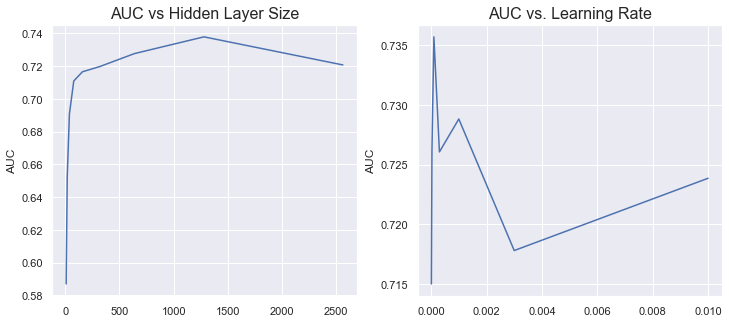

In [95]:
f, ax = plt.subplots(1,2, figsize=(12, 5))
sns.lineplot(x='Hidden Layer Size', y='AUC', data=pd.DataFrame({'Hidden Layer Size':hs, 'AUC':aucs0}), ax=ax[0])
ax[0].set_title("AUC vs Hidden Layer Size", fontsize=16)
ax[0].set(xlabel='', ylabel='AUC')

sns.lineplot(x='Learning Rate', y='AUC', data=pd.DataFrame({'Learning Rate':lrs, 'AUC':aucs1}), ax=ax[1])
ax[1].set_title("AUC vs. Learning Rate", fontsize=16)
ax[1].set(xlabel='', ylabel='AUC')

In [350]:
def trainTooLong(h):
    n_folds = 5
    n_loops = 1
    skf = StratifiedKFold(n_splits=n_folds)

    for train_index, test_index in skf.split(X, y):
        print("new training")
        X_tr, X_val = X[train_index], X[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        data = [X_tr, X_val, y_tr, y_val]
        net, aucs = training_loop(h, 0.0003, *data, use_early_stopping=False)
        break

    epoch = [e[0] for e in aucs][:-3]
    aucs_tr = [e[1] for e in aucs]
    aucs_tr_ma = aucs_tr[0:2]
    aucs_val = [e[2] for e in aucs]
    aucs_val_ma = aucs_val[0:2]

    for i in range(2, len(aucs_tr)-3):
        aucs_tr_ma.append(sum(aucs_tr[i-2:i+3])/5)
        aucs_val_ma.append(sum(aucs_val[i-2:i+3])/5)
        
    return aucs_tr_ma, aucs_val_ma
        
aucs_tr_ma_200, aucs_val_ma_200 = trainTooLong(200)
aucs_tr_ma_2000, aucs_val_ma_2000 = trainTooLong(2000)

3it [00:00, 25.07it/s]

new training
# of positive examples: 418, # of negative examples: 400


299it [00:16, 18.36it/s]
1it [00:00,  9.64it/s]

new training
# of positive examples: 418, # of negative examples: 400


299it [00:38,  7.87it/s]


[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'AUC')]

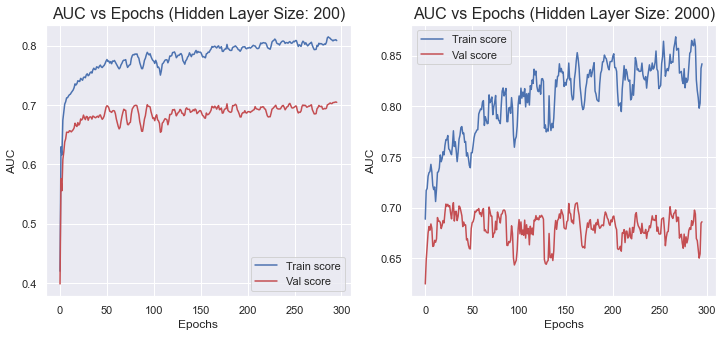

In [351]:
f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(epoch, aucs_tr_ma_200, '-', color="b", label="Train score")
ax[0].plot(epoch, aucs_val_ma_200, '-', color="r", label="Val score")
ax[0].legend()
ax[0].set_title("AUC vs Epochs (Hidden Layer Size: 200)", fontsize=16)
ax[0].set(xlabel='Epochs', ylabel='AUC')

ax[1].plot(epoch, aucs_tr_ma_2000, '-', color="b", label="Train score")
ax[1].plot(epoch, aucs_val_ma_2000, '-', color="r", label="Val score")
ax[1].legend()
ax[1].set_title("AUC vs Epochs (Hidden Layer Size: 2000)", fontsize=16)
ax[1].set(xlabel='Epochs', ylabel='AUC')

40it [00:00, 198.55it/s]

# of positive examples: 4, # of negative examples: 4


53it [00:00, 190.47it/s]
18it [00:00, 178.70it/s]

0.41601107834827566
# of positive examples: 3, # of negative examples: 5


64it [00:00, 170.22it/s]
11it [00:00, 158.68it/s]
16it [00:00, 154.26it/s]

0.4445873832666285
# of positive examples: 4, # of negative examples: 4
0.47020306325880123
# of positive examples: 6, # of negative examples: 2


93it [00:00, 152.48it/s]
11it [00:00, 159.85it/s]
16it [00:00, 156.50it/s]

0.5636459569977575
# of positive examples: 4, # of negative examples: 4
0.3522747621378347
# of positive examples: 3, # of negative examples: 5


52it [00:00, 151.56it/s]
15it [00:00, 145.30it/s]

0.5980083857442349
# of positive examples: 5, # of negative examples: 3


95it [00:00, 146.09it/s]
16it [00:00, 149.93it/s]

0.6718951902368988
# of positive examples: 5, # of negative examples: 3


110it [00:00, 145.88it/s]
15it [00:00, 146.02it/s]

0.7254905479779852
# of positive examples: 4, # of negative examples: 4


48it [00:00, 145.62it/s]
15it [00:00, 143.91it/s]

0.4487089187866344
# of positive examples: 5, # of negative examples: 3


34it [00:00, 143.23it/s]
16it [00:00, 151.35it/s]

0.6593622876286194
0.6994444444444444 0.535018757438367
# of positive examples: 4, # of negative examples: 4


31it [00:00, 143.56it/s]
12it [00:00, 124.65it/s]
0it [00:00, ?it/s]

0.4114985614860267
# of positive examples: 3, # of negative examples: 5
0.5850545549838003
# of positive examples: 3, # of negative examples: 5


11it [00:00, 123.93it/s]
14it [00:00, 138.29it/s]

0.534525681341719
# of positive examples: 6, # of negative examples: 2


53it [00:00, 144.01it/s]
17it [00:00, 163.10it/s]

0.5198462663836625
# of positive examples: 5, # of negative examples: 3


42it [00:00, 149.85it/s]
15it [00:00, 143.24it/s]

0.4958004307250538
# of positive examples: 5, # of negative examples: 3


59it [00:00, 140.51it/s]
15it [00:00, 141.89it/s]

0.6562574778655181
# of positive examples: 5, # of negative examples: 3


34it [00:00, 138.86it/s]
14it [00:00, 138.29it/s]

0.6972481454893515
# of positive examples: 3, # of negative examples: 5


26it [00:00, 139.77it/s]
15it [00:00, 142.55it/s]

0.6442729178578236
0.6232638888888888 0.5680630045166194
# of positive examples: 5, # of negative examples: 4


116it [00:00, 126.35it/s]
13it [00:00, 129.69it/s]

0.4853604414057815
# of positive examples: 4, # of negative examples: 5


55it [00:00, 136.83it/s]
18it [00:00, 131.25it/s]
0it [00:00, ?it/s]

0.38929580161807653
# of positive examples: 5, # of negative examples: 4
0.7006597097277197
# of positive examples: 4, # of negative examples: 5


56it [00:00, 127.90it/s]
14it [00:00, 135.62it/s]

0.5291062281583608
# of positive examples: 6, # of negative examples: 3


51it [00:00, 131.62it/s]
14it [00:00, 131.19it/s]

0.43823182900146673
# of positive examples: 3, # of negative examples: 6


136it [00:01, 123.23it/s]
11it [00:00, 106.05it/s]
0it [00:00, ?it/s]

0.4875806066395988
# of positive examples: 4, # of negative examples: 5
0.5209141174780986
# of positive examples: 5, # of negative examples: 4


106it [00:01, 104.34it/s]
11it [00:00, 126.03it/s]
0it [00:00, ?it/s]

0.5614909439846467
# of positive examples: 6, # of negative examples: 3
0.5733331730422447
0.6564814814814813 0.5206636501173327
# of positive examples: 7, # of negative examples: 3


116it [00:00, 128.09it/s]
14it [00:00, 138.99it/s]

0.47617897178198687
# of positive examples: 5, # of negative examples: 5


34it [00:00, 134.48it/s]
13it [00:00, 127.79it/s]

0.5382094757094757
# of positive examples: 4, # of negative examples: 6


89it [00:00, 129.79it/s]
11it [00:00, 136.99it/s]
0it [00:00, ?it/s]

0.5638190653308537
# of positive examples: 6, # of negative examples: 4
0.2818989309775469
# of positive examples: 6, # of negative examples: 4


104it [00:00, 127.47it/s]
11it [00:00, 116.10it/s]
0it [00:00, ?it/s]

0.6298374169910694
# of positive examples: 5, # of negative examples: 5
0.597540885040885
# of positive examples: 5, # of negative examples: 5


68it [00:00, 122.85it/s]
11it [00:00, 125.34it/s]
11it [00:00, 128.98it/s]

0.6417809042809042
# of positive examples: 3, # of negative examples: 7
0.5184129872617567
# of positive examples: 6, # of negative examples: 4



11it [00:00, 108.13it/s]
0it [00:00, ?it/s]

0.5232304484591372
# of positive examples: 7, # of negative examples: 3
0.21669646308465404
0.5375 0.4987605548918269
# of positive examples: 5, # of negative examples: 5


33it [00:00, 131.83it/s]
13it [00:00, 121.82it/s]

0.5050685425685426
# of positive examples: 6, # of negative examples: 4


64it [00:00, 119.60it/s]
13it [00:00, 131.67it/s]
0it [00:00, ?it/s]

0.6507960420859799
# of positive examples: 7, # of negative examples: 3
0.52563901236954
# of positive examples: 8, # of negative examples: 2


65it [00:00, 121.70it/s]
17it [00:00, 105.54it/s]
0it [00:00, ?it/s]

0.5390771615027908
# of positive examples: 5, # of negative examples: 5
0.617027417027417
# of positive examples: 4, # of negative examples: 6


68it [00:00, 116.25it/s]
11it [00:00, 115.48it/s]
0it [00:00, ?it/s]

0.44421980922670823
# of positive examples: 3, # of negative examples: 7
0.46450292117613257
# of positive examples: 6, # of negative examples: 4


18it [00:00, 125.33it/s]
13it [00:00, 122.97it/s]

0.5558856495486483
# of positive examples: 8, # of negative examples: 2


94it [00:00, 132.84it/s]
13it [00:00, 123.54it/s]

0.5437688423958447
# of positive examples: 4, # of negative examples: 6


107it [00:00, 125.55it/s]
14it [00:00, 131.19it/s]

0.4859979602855601
0.7063095238095238 0.5331983358187163
# of positive examples: 5, # of negative examples: 7


61it [00:00, 123.56it/s]
12it [00:00, 112.96it/s]

0.5406692809199606
# of positive examples: 5, # of negative examples: 7


76it [00:00, 122.60it/s]
13it [00:00, 122.97it/s]

0.542816416869151
# of positive examples: 5, # of negative examples: 7


22it [00:00, 116.40it/s]
13it [00:00, 121.82it/s]

0.5742115139413477
# of positive examples: 6, # of negative examples: 6


58it [00:00, 115.84it/s]
14it [00:00, 131.80it/s]

0.5796262808921037
# of positive examples: 7, # of negative examples: 5


42it [00:00, 126.08it/s]
11it [00:00, 126.04it/s]
0it [00:00, ?it/s]

0.5865231259968102
# of positive examples: 5, # of negative examples: 7
0.5552421391969591
# of positive examples: 5, # of negative examples: 7


30it [00:00, 122.02it/s]
13it [00:00, 125.92it/s]

0.45521086438761516
# of positive examples: 8, # of negative examples: 4


102it [00:00, 130.11it/s]
12it [00:00, 132.94it/s]
0it [00:00, ?it/s]

0.5295667021894982
# of positive examples: 6, # of negative examples: 6
0.5649547920433997
# of positive examples: 5, # of negative examples: 7


29it [00:00, 121.41it/s]
14it [00:00, 123.66it/s]
0it [00:00, ?it/s]

0.3787259123824187
0.6751587301587303 0.5307547028819265
# of positive examples: 5, # of negative examples: 8
0.4495917899738311
# of positive examples: 5, # of negative examples: 8


19it [00:00, 125.74it/s]
14it [00:00, 131.19it/s]

0.6933781942283805
# of positive examples: 5, # of negative examples: 8


171it [00:01, 129.89it/s]
14it [00:00, 134.97it/s]

0.5158279367606092
# of positive examples: 5, # of negative examples: 8


54it [00:00, 134.01it/s]
15it [00:00, 140.56it/s]

0.3375299977087177
# of positive examples: 8, # of negative examples: 5


54it [00:00, 135.35it/s]
11it [00:00, 128.98it/s]
0it [00:00, ?it/s]

0.6154149669774671
# of positive examples: 7, # of negative examples: 6
0.7077402943492218
# of positive examples: 5, # of negative examples: 8


13it [00:00, 129.06it/s]
16it [00:00, 127.82it/s]
0it [00:00, ?it/s]

0.47823281839779075
# of positive examples: 6, # of negative examples: 7
0.595479816291999
# of positive examples: 8, # of negative examples: 5


78it [00:00, 125.73it/s]
15it [00:00, 125.33it/s]
0it [00:00, ?it/s]

0.6640078671328672
# of positive examples: 7, # of negative examples: 6
0.5122524377687603
0.6118571428571429 0.5569456119589644
# of positive examples: 6, # of negative examples: 8


82it [00:00, 123.44it/s]
11it [00:00, 132.88it/s]
0it [00:00, ?it/s]

0.6339997576638798
# of positive examples: 8, # of negative examples: 6
0.5153967867575462
# of positive examples: 8, # of negative examples: 6


11it [00:00, 131.30it/s]
13it [00:00, 127.79it/s]

0.5102604673807205
# of positive examples: 6, # of negative examples: 8


29it [00:00, 121.91it/s]
13it [00:00, 126.55it/s]

0.46043256997455473
# of positive examples: 6, # of negative examples: 8


70it [00:00, 122.38it/s]
13it [00:00, 127.16it/s]

0.4901248031019023
# of positive examples: 7, # of negative examples: 7


33it [00:00, 110.65it/s]
12it [00:00, 119.13it/s]
0it [00:00, ?it/s]

0.44432030699730407
# of positive examples: 7, # of negative examples: 7
0.5976428727564181
# of positive examples: 7, # of negative examples: 7


43it [00:00, 127.93it/s]
13it [00:00, 122.38it/s]

0.6890862944162437
# of positive examples: 7, # of negative examples: 7


75it [00:00, 124.19it/s]
13it [00:00, 128.40it/s]

0.580064605445316
# of positive examples: 11, # of negative examples: 3


79it [00:00, 125.72it/s]
12it [00:00, 119.13it/s]

0.565700453486947
0.7611904761904762 0.5487028917980833
# of positive examples: 7, # of negative examples: 9


36it [00:00, 117.00it/s]
12it [00:00, 118.53it/s]
0it [00:00, ?it/s]

0.6989431486880465
# of positive examples: 10, # of negative examples: 6
0.5727144866385373
# of positive examples: 5, # of negative examples: 11


11it [00:00, 113.71it/s]
11it [00:00, 117.95it/s]
0it [00:00, ?it/s]

0.44969762941461056
# of positive examples: 9, # of negative examples: 7
0.5609381101132371
# of positive examples: 9, # of negative examples: 7


37it [00:00, 112.41it/s]
13it [00:00, 111.41it/s]
0it [00:00, ?it/s]

0.566282702069504
# of positive examples: 9, # of negative examples: 7
0.5296270987895353
# of positive examples: 11, # of negative examples: 5


126it [00:01, 116.97it/s]
12it [00:00, 111.92it/s]

0.5653684907325685
# of positive examples: 10, # of negative examples: 6


29it [00:00, 112.05it/s]
12it [00:00, 116.24it/s]
0it [00:00, ?it/s]

0.6889500397480585
# of positive examples: 9, # of negative examples: 7
0.48976840101522845
# of positive examples: 10, # of negative examples: 6


91it [00:00, 119.74it/s]
11it [00:00, 126.04it/s]
0it [00:00, ?it/s]

0.7033877575979941
0.5590740740740741 0.582567786480732
# of positive examples: 8, # of negative examples: 10
0.6395636265739914
# of positive examples: 7, # of negative examples: 11


51it [00:00, 125.64it/s]
14it [00:00, 131.19it/s]

0.4825885225885226
# of positive examples: 9, # of negative examples: 9


49it [00:00, 124.06it/s]
11it [00:00, 104.05it/s]

0.5989808182888541
# of positive examples: 8, # of negative examples: 10


65it [00:00, 108.89it/s]
11it [00:00, 117.95it/s]
0it [00:00, ?it/s]

0.5626231353785532
# of positive examples: 10, # of negative examples: 8
0.5989170385121265
# of positive examples: 7, # of negative examples: 11


11it [00:00, 119.88it/s]
12it [00:00, 117.37it/s]

0.5169230769230769
# of positive examples: 8, # of negative examples: 10


30it [00:00, 116.81it/s]
11it [00:00, 109.20it/s]

0.6275284817484307
# of positive examples: 9, # of negative examples: 9


41it [00:00, 106.77it/s]
11it [00:00, 113.71it/s]
0it [00:00, ?it/s]

0.6566853905023547
# of positive examples: 5, # of negative examples: 13
0.6906122349737405
# of positive examples: 7, # of negative examples: 11


11it [00:00, 84.51it/s]
11it [00:00, 113.70it/s]
0it [00:00, ?it/s]

0.5711294261294262
0.5970206876456876 0.5945551751619076
# of positive examples: 12, # of negative examples: 8
0.5014081375528052
# of positive examples: 11, # of negative examples: 9


25it [00:00, 110.18it/s]
11it [00:00, 117.34it/s]
0it [00:00, ?it/s]

0.5224169377896087
# of positive examples: 11, # of negative examples: 9
0.44999630286897363
# of positive examples: 6, # of negative examples: 14


11it [00:00, 102.59it/s]
11it [00:00, 119.22it/s]
0it [00:00, ?it/s]

0.4479791331480669
# of positive examples: 9, # of negative examples: 11
0.6343516132989817
# of positive examples: 11, # of negative examples: 9


11it [00:00, 128.25it/s]
14it [00:00, 131.80it/s]

0.435756186532584
# of positive examples: 12, # of negative examples: 8


157it [00:01, 122.26it/s]
13it [00:00, 125.34it/s]

0.6840707527359866
# of positive examples: 10, # of negative examples: 10


50it [00:00, 126.59it/s]
11it [00:00, 125.34it/s]
0it [00:00, ?it/s]

0.5076541904387173
# of positive examples: 11, # of negative examples: 9
0.6657177363699103
# of positive examples: 10, # of negative examples: 10


75it [00:00, 116.67it/s]
19it [00:00, 118.69it/s]
0it [00:00, ?it/s]

0.49098711390910876
0.5506911976911977 0.5340338104644744
# of positive examples: 11, # of negative examples: 10
0.5358365148201687
# of positive examples: 7, # of negative examples: 14


11it [00:00, 112.55it/s]
12it [00:00, 114.04it/s]

0.5420110951908593
# of positive examples: 10, # of negative examples: 11


58it [00:00, 123.86it/s]
14it [00:00, 131.19it/s]

0.6610576923076924
# of positive examples: 10, # of negative examples: 11


28it [00:00, 121.79it/s]
13it [00:00, 127.16it/s]

0.685096153846154
# of positive examples: 10, # of negative examples: 11


117it [00:00, 127.44it/s]
12it [00:00, 117.38it/s]

0.586612426035503
# of positive examples: 11, # of negative examples: 10


64it [00:00, 121.18it/s]
13it [00:00, 124.14it/s]

0.6925015752993069
# of positive examples: 12, # of negative examples: 9


49it [00:00, 114.52it/s]
11it [00:00, 109.74it/s]

0.40885055478502086
# of positive examples: 13, # of negative examples: 8


82it [00:00, 117.45it/s]
13it [00:00, 129.06it/s]

0.6807608763110533
# of positive examples: 11, # of negative examples: 10


106it [00:00, 122.16it/s]
12it [00:00, 119.13it/s]

0.5026131435560992
# of positive examples: 9, # of negative examples: 12


60it [00:00, 117.15it/s]
13it [00:00, 123.54it/s]

0.6312345481605393
0.6927836399711399 0.5926574580312397
# of positive examples: 10, # of negative examples: 14


75it [00:00, 120.42it/s]
13it [00:00, 128.41it/s]

0.5121471755498684
# of positive examples: 9, # of negative examples: 15


97it [00:00, 126.63it/s]
11it [00:00, 126.77it/s]
0it [00:00, ?it/s]

0.477979274611399
# of positive examples: 9, # of negative examples: 15
0.29710091290402174
# of positive examples: 14, # of negative examples: 10


21it [00:00, 125.70it/s]
14it [00:00, 131.80it/s]

0.657738132368536
# of positive examples: 15, # of negative examples: 9


118it [00:00, 123.56it/s]
11it [00:00, 125.34it/s]
0it [00:00, ?it/s]

0.685968137254902
# of positive examples: 14, # of negative examples: 10
0.6508639510947538
# of positive examples: 11, # of negative examples: 13


12it [00:00, 124.04it/s]
11it [00:00, 113.11it/s]
0it [00:00, ?it/s]

0.5920772204599525
# of positive examples: 10, # of negative examples: 14
0.384227835268227
# of positive examples: 11, # of negative examples: 13


13it [00:00, 125.34it/s]
13it [00:00, 125.93it/s]

0.5122236816019032
# of positive examples: 13, # of negative examples: 11


48it [00:00, 123.40it/s]
13it [00:00, 122.38it/s]

0.6599203385611152
0.6909676280509613 0.543024665967468
# of positive examples: 11, # of negative examples: 15


42it [00:00, 118.29it/s]
18it [00:00, 111.75it/s]
0it [00:00, ?it/s]

0.4250822040653646
# of positive examples: 14, # of negative examples: 12
0.5179948586118251
# of positive examples: 14, # of negative examples: 12


62it [00:00, 109.05it/s]
13it [00:00, 120.69it/s]

0.42156875039187414
# of positive examples: 15, # of negative examples: 11


96it [00:00, 110.06it/s]
11it [00:00, 111.41it/s]
0it [00:00, ?it/s]

0.6687091503267975
# of positive examples: 11, # of negative examples: 15
0.4627403846153847
# of positive examples: 14, # of negative examples: 12


38it [00:00, 119.81it/s]
11it [00:00, 109.74it/s]
0it [00:00, ?it/s]

0.5226659978682049
# of positive examples: 12, # of negative examples: 14
0.7021183637294187
# of positive examples: 13, # of negative examples: 13


53it [00:00, 113.79it/s]
13it [00:00, 124.72it/s]

0.6108122310079072
# of positive examples: 10, # of negative examples: 16


64it [00:00, 117.85it/s]
11it [00:00, 110.29it/s]
0it [00:00, ?it/s]

0.7032374324240354
# of positive examples: 13, # of negative examples: 13
0.7286370233209889
0.6074974157786658 0.5763566396361801
# of positive examples: 17, # of negative examples: 12


11it [00:00, 107.59it/s]
11it [00:00, 113.57it/s]
0it [00:00, ?it/s]

0.49968341205820155
# of positive examples: 17, # of negative examples: 12
0.5501222029455343
# of positive examples: 17, # of negative examples: 12


70it [00:00, 117.36it/s]
11it [00:00, 118.60it/s]
11it [00:00, 124.62it/s]

0.644465409601479
# of positive examples: 16, # of negative examples: 13
0.6776329088336366
# of positive examples: 17, # of negative examples: 12



11it [00:00, 125.34it/s]
0it [00:00, ?it/s]

0.5328744918763535
# of positive examples: 14, # of negative examples: 15
0.6207995875044017
# of positive examples: 16, # of negative examples: 13


82it [00:00, 128.97it/s]
13it [00:00, 126.55it/s]

0.5900419446128967
# of positive examples: 15, # of negative examples: 14


48it [00:00, 121.22it/s]
13it [00:00, 125.33it/s]

0.6219197075691687
# of positive examples: 13, # of negative examples: 16


86it [00:00, 124.09it/s]
11it [00:00, 109.20it/s]
0it [00:00, ?it/s]

0.37145366710584105
# of positive examples: 11, # of negative examples: 18
0.6286619111272127
0.6107493894993895 0.5737655243234726
# of positive examples: 15, # of negative examples: 17


11it [00:00, 111.96it/s]
11it [00:00, 117.33it/s]
0it [00:00, ?it/s]

0.5161938713592233
# of positive examples: 18, # of negative examples: 14
0.6848308957370706
# of positive examples: 16, # of negative examples: 16


44it [00:00, 114.88it/s]
23it [00:00, 119.79it/s]

0.6156857776369971
# of positive examples: 13, # of negative examples: 19



12it [00:00, 120.91it/s]
0it [00:00, ?it/s]

0.5498137333870318
# of positive examples: 19, # of negative examples: 13
0.5921519342655914
# of positive examples: 16, # of negative examples: 16


11it [00:00, 104.05it/s]
12it [00:00, 115.71it/s]

0.39782071586949636
# of positive examples: 16, # of negative examples: 16


29it [00:00, 109.93it/s]
11it [00:00, 110.29it/s]
0it [00:00, ?it/s]

0.543807412100095
# of positive examples: 16, # of negative examples: 16
0.5917896737408933
# of positive examples: 13, # of negative examples: 19


22it [00:00, 113.71it/s]
12it [00:00, 114.59it/s]

0.5039267015706806
# of positive examples: 14, # of negative examples: 18


47it [00:00, 112.74it/s]
12it [00:00, 114.59it/s]

0.4545540545654066
0.5408353114893363 0.5450574770232486
# of positive examples: 16, # of negative examples: 18


111it [00:00, 114.79it/s]
11it [00:00, 117.34it/s]
0it [00:00, ?it/s]

0.6730688403489778
# of positive examples: 18, # of negative examples: 16
0.5604311944213421
# of positive examples: 15, # of negative examples: 19


29it [00:00, 112.27it/s]
11it [00:00, 116.70it/s]
0it [00:00, ?it/s]

0.4863645605652417
# of positive examples: 12, # of negative examples: 22
0.48123997929580486
# of positive examples: 13, # of negative examples: 21


37it [00:00, 119.47it/s]
12it [00:00, 118.53it/s]

0.4933451417004048
# of positive examples: 17, # of negative examples: 17


120it [00:01, 118.19it/s]
11it [00:00, 106.05it/s]

0.47018612132352944
# of positive examples: 16, # of negative examples: 18


48it [00:00, 104.85it/s]
12it [00:00, 104.17it/s]
0it [00:00, ?it/s]

0.6412851047570528
# of positive examples: 20, # of negative examples: 14
0.4473241029992159
# of positive examples: 21, # of negative examples: 13


20it [00:00, 100.01it/s]
10it [00:00, 96.41it/s]

0.5016881443298968
# of positive examples: 19, # of negative examples: 15


57it [00:00, 100.18it/s]
12it [00:00, 111.92it/s]

0.563343251423588
0.5669241828102568 0.5318276441165055
# of positive examples: 18, # of negative examples: 20


80it [00:00, 92.68it/s] 
11it [00:00, 84.20it/s]
0it [00:00, ?it/s]

0.46172353455818027
# of positive examples: 18, # of negative examples: 20
0.26156656888477176
# of positive examples: 23, # of negative examples: 15


37it [00:00, 99.99it/s] 
11it [00:00, 105.53it/s]

0.5495352409716978
# of positive examples: 15, # of negative examples: 23


28it [00:00, 104.17it/s]
11it [00:00, 104.05it/s]

0.5285637604478184
# of positive examples: 21, # of negative examples: 17


93it [00:00, 105.30it/s]
11it [00:00, 108.65it/s]

0.7020820377280267
# of positive examples: 18, # of negative examples: 20


33it [00:00, 101.80it/s]
11it [00:00, 98.03it/s] 
0it [00:00, ?it/s]

0.5971900571252122
# of positive examples: 16, # of negative examples: 22
0.510874298742219
# of positive examples: 22, # of negative examples: 16


145it [00:01, 96.40it/s]
9it [00:00, 83.56it/s]

0.6462012987012987
# of positive examples: 19, # of negative examples: 19


24it [00:00, 81.16it/s]
11it [00:00, 94.25it/s] 
0it [00:00, ?it/s]

0.5463208934052046
# of positive examples: 23, # of negative examples: 15
0.5051422917697295
0.5912334832051483 0.5309199982334158
# of positive examples: 17, # of negative examples: 24


16it [00:00, 86.25it/s]
11it [00:00, 101.64it/s]

0.6301537431433648
# of positive examples: 20, # of negative examples: 21


80it [00:00, 104.30it/s]
11it [00:00, 105.53it/s]

0.614862587503241
# of positive examples: 26, # of negative examples: 15


27it [00:00, 101.20it/s]
10it [00:00, 99.27it/s]

0.6586557428789355
# of positive examples: 25, # of negative examples: 16


41it [00:00, 94.07it/s]
11it [00:00, 104.05it/s]

0.4850321395775941
# of positive examples: 18, # of negative examples: 23


20it [00:00, 102.05it/s]
18it [00:00, 98.89it/s] 

0.5189185701380823
# of positive examples: 21, # of negative examples: 20



10it [00:00, 99.27it/s]

0.6618201190197759
# of positive examples: 18, # of negative examples: 23


48it [00:00, 99.33it/s] 
10it [00:00, 99.28it/s]

0.4497419021809266
# of positive examples: 20, # of negative examples: 21


32it [00:00, 97.08it/s] 
11it [00:00, 101.64it/s]

0.5973878662172674
# of positive examples: 22, # of negative examples: 19


39it [00:00, 98.00it/s] 
11it [00:00, 102.59it/s]
0it [00:00, ?it/s]

0.5490023703472168
# of positive examples: 19, # of negative examples: 22
0.5698561746598376
0.602678907826219 0.5735431215666241
# of positive examples: 25, # of negative examples: 21


46it [00:00, 98.76it/s] 
14it [00:00, 103.98it/s]
0it [00:00, ?it/s]

0.6312814070351759
# of positive examples: 22, # of negative examples: 24
0.5580796806471098
# of positive examples: 24, # of negative examples: 22


70it [00:00, 100.26it/s]
10it [00:00, 97.81it/s]

0.6015303430079155
# of positive examples: 26, # of negative examples: 20


128it [00:01, 100.62it/s]
11it [00:00, 107.08it/s]

0.6649964209019328
# of positive examples: 23, # of negative examples: 23


230it [00:02, 111.05it/s]
11it [00:00, 109.73it/s]

0.5087920187422675
# of positive examples: 24, # of negative examples: 22


39it [00:00, 108.31it/s]
12it [00:00, 114.04it/s]

0.48683377308707126
# of positive examples: 28, # of negative examples: 18


153it [00:01, 112.14it/s]
11it [00:00, 106.05it/s]

0.6975675387648532
# of positive examples: 27, # of negative examples: 19


57it [00:00, 106.03it/s]
11it [00:00, 104.05it/s]

0.39123501740771255
# of positive examples: 23, # of negative examples: 23


50it [00:00, 100.44it/s]
11it [00:00, 103.08it/s]

0.5270209797572982
# of positive examples: 27, # of negative examples: 19


33it [00:00, 99.06it/s] 
10it [00:00, 94.14it/s]

0.5722486512344859
0.620934318529063 0.5639585830585824
# of positive examples: 28, # of negative examples: 22


42it [00:00, 101.26it/s]
10it [00:00, 99.76it/s]

0.6092977780158847
# of positive examples: 32, # of negative examples: 18


33it [00:00, 94.26it/s]
12it [00:00, 110.39it/s]

0.5953476102219998
# of positive examples: 25, # of negative examples: 25


64it [00:00, 107.75it/s]
11it [00:00, 107.59it/s]

0.38738696808510636
# of positive examples: 28, # of negative examples: 22


37it [00:00, 105.69it/s]
11it [00:00, 104.53it/s]
0it [00:00, ?it/s]

0.623910102728259
# of positive examples: 25, # of negative examples: 25
0.7247140957446808
# of positive examples: 28, # of negative examples: 22


13it [00:00, 105.12it/s]
12it [00:00, 118.53it/s]

0.5421159074775993
# of positive examples: 30, # of negative examples: 20


58it [00:00, 113.02it/s]
12it [00:00, 111.92it/s]

0.4856383336698297
# of positive examples: 28, # of negative examples: 22


46it [00:00, 101.14it/s]
11it [00:00, 106.55it/s]

0.70589180718696
# of positive examples: 22, # of negative examples: 28


47it [00:00, 96.27it/s] 
11it [00:00, 96.32it/s] 
0it [00:00, ?it/s]

0.6359566291155456
# of positive examples: 22, # of negative examples: 28
0.45929687396822466
0.5992350496725497 0.576955610621409
# of positive examples: 28, # of negative examples: 28


27it [00:00, 101.58it/s]
11it [00:00, 107.59it/s]

0.5997211257359183
# of positive examples: 27, # of negative examples: 29


85it [00:00, 98.81it/s] 
10it [00:00, 99.28it/s]

0.6072916666666667
# of positive examples: 28, # of negative examples: 28


94it [00:00, 100.00it/s]
11it [00:00, 108.13it/s]

0.6622657523542647
# of positive examples: 34, # of negative examples: 22


43it [00:00, 101.68it/s]
11it [00:00, 103.55it/s]

0.6063133142849332
# of positive examples: 30, # of negative examples: 26


25it [00:00, 95.13it/s] 
10it [00:00, 94.14it/s]

0.5895025380710659
# of positive examples: 33, # of negative examples: 23


134it [00:01, 98.17it/s]
11it [00:00, 101.20it/s]

0.5897902689139802
# of positive examples: 28, # of negative examples: 28


84it [00:00, 98.27it/s] 
13it [00:00, 94.11it/s] 
0it [00:00, ?it/s]

0.5373246931709486
# of positive examples: 27, # of negative examples: 29
0.6782795698924731
# of positive examples: 31, # of negative examples: 25


46it [00:00, 96.69it/s] 
9it [00:00, 89.78it/s]

0.6284126682587929
# of positive examples: 25, # of negative examples: 31


86it [00:00, 89.49it/s]
9it [00:00, 88.03it/s]

0.5110248862724109
0.5978549053937361 0.6009926483621454
# of positive examples: 33, # of negative examples: 28


35it [00:00, 86.43it/s]
10it [00:00, 93.71it/s]

0.5309548360486698
# of positive examples: 30, # of negative examples: 31


38it [00:00, 89.44it/s]
11it [00:00, 87.88it/s]
0it [00:00, ?it/s]

0.3512967512967513
# of positive examples: 30, # of negative examples: 31
0.49484029484029485
# of positive examples: 32, # of negative examples: 29


28it [00:00, 95.66it/s]
10it [00:00, 98.78it/s]

0.5173633969716919
# of positive examples: 28, # of negative examples: 33


26it [00:00, 93.10it/s]
13it [00:00, 101.05it/s]
0it [00:00, ?it/s]

0.5722418478260869
# of positive examples: 33, # of negative examples: 28
0.5787722554478587
# of positive examples: 31, # of negative examples: 30


55it [00:00, 97.34it/s]
11it [00:00, 91.15it/s] 
0it [00:00, ?it/s]

0.5535457742142925
# of positive examples: 25, # of negative examples: 36
0.2961198461434645
# of positive examples: 27, # of negative examples: 34


36it [00:00, 94.98it/s]
9it [00:00, 84.72it/s]

0.4921509618121924
# of positive examples: 30, # of negative examples: 31


16it [00:00, 80.81it/s]
8it [00:00, 79.81it/s]

0.5160865410865412
0.5434017992365912 0.49033725056878447
# of positive examples: 30, # of negative examples: 36


33it [00:00, 75.11it/s]
9it [00:00, 80.57it/s]

0.5659461692021752
# of positive examples: 32, # of negative examples: 34


32it [00:00, 74.27it/s]
11it [00:00, 79.06it/s]
0it [00:00, ?it/s]

0.6114469079793634
# of positive examples: 34, # of negative examples: 32
0.5613855882148564
# of positive examples: 34, # of negative examples: 32


43it [00:00, 81.50it/s]
9it [00:00, 88.47it/s]

0.5453686331735113
# of positive examples: 34, # of negative examples: 32


51it [00:00, 84.59it/s]
11it [00:00, 81.10it/s]
0it [00:00, ?it/s]

0.5185949551803211
# of positive examples: 30, # of negative examples: 36
0.6182487781372616
# of positive examples: 34, # of negative examples: 32


20it [00:00, 87.56it/s]
9it [00:00, 84.34it/s]

0.5207143353484817
# of positive examples: 35, # of negative examples: 31


56it [00:00, 83.00it/s]
9it [00:00, 88.03it/s]

0.5643563666759543
# of positive examples: 33, # of negative examples: 33


64it [00:00, 78.88it/s]
9it [00:00, 84.34it/s]

0.6550022182786157
# of positive examples: 36, # of negative examples: 30


52it [00:00, 83.75it/s]
6it [00:00, 58.12it/s]

0.6068740136586456
0.6475009148415501 0.5767937965849186
# of positive examples: 34, # of negative examples: 39


58it [00:00, 73.61it/s]
9it [00:00, 79.50it/s]

0.5981293995568893
# of positive examples: 38, # of negative examples: 35


33it [00:00, 72.80it/s]
9it [00:00, 82.04it/s]

0.6075837367988901
# of positive examples: 37, # of negative examples: 36


26it [00:00, 82.63it/s]
10it [00:00, 90.73it/s]

0.5531422115520406
# of positive examples: 38, # of negative examples: 35


20it [00:00, 84.97it/s]
9it [00:00, 81.30it/s]

0.586893739913361
# of positive examples: 36, # of negative examples: 37


15it [00:00, 69.46it/s]
8it [00:00, 70.99it/s]

0.6235136658213581
# of positive examples: 36, # of negative examples: 37


47it [00:00, 79.13it/s]
11it [00:00, 80.79it/s]
0it [00:00, ?it/s]

0.5536770921386306
# of positive examples: 33, # of negative examples: 40
0.47106802092951683
# of positive examples: 38, # of negative examples: 35


11it [00:00, 78.49it/s]
9it [00:00, 84.72it/s]

0.5767363175627849
# of positive examples: 37, # of negative examples: 36


67it [00:00, 78.61it/s]
11it [00:00, 66.64it/s]

0.6725180059313656
# of positive examples: 37, # of negative examples: 36



11it [00:00, 69.14it/s]


0.4547662759497245
0.5644798287298287 0.5698028466154561
# of positive examples: 41, # of negative examples: 39
0.586448261970534
# of positive examples: 39, # of negative examples: 41


18it [00:00, 67.97it/s]
11it [00:00, 67.04it/s]


0.6519258304696449
# of positive examples: 41, # of negative examples: 39
0.5338541666666667
# of positive examples: 38, # of negative examples: 42


11it [00:00, 61.10it/s]
7it [00:00, 69.49it/s]

0.5690807799442897
# of positive examples: 42, # of negative examples: 38


26it [00:00, 71.22it/s]
8it [00:00, 73.59it/s]

0.6433877085947528
# of positive examples: 37, # of negative examples: 43


32it [00:00, 72.42it/s]
11it [00:00, 70.02it/s]
0it [00:00, ?it/s]

0.4816583057804128
# of positive examples: 42, # of negative examples: 38
0.4655719498651436
# of positive examples: 38, # of negative examples: 42


25it [00:00, 67.93it/s]
8it [00:00, 72.58it/s]

0.4694664666809514
# of positive examples: 41, # of negative examples: 39


71it [00:00, 76.17it/s]
8it [00:00, 79.42it/s]

0.6003395488029466
# of positive examples: 41, # of negative examples: 39


33it [00:00, 75.37it/s]
8it [00:00, 79.81it/s]

0.4832527624309392
0.5889153665699063 0.5484985781206281
# of positive examples: 50, # of negative examples: 38


30it [00:00, 73.01it/s]
8it [00:00, 79.81it/s]

0.6752438388802026
# of positive examples: 42, # of negative examples: 46


35it [00:00, 77.55it/s]
8it [00:00, 75.67it/s]

0.5873896227103553
# of positive examples: 43, # of negative examples: 45


44it [00:00, 78.71it/s]
8it [00:00, 78.64it/s]

0.5532830056179775
# of positive examples: 42, # of negative examples: 46


81it [00:01, 78.05it/s]
8it [00:00, 78.25it/s]

0.6736189155659346
# of positive examples: 40, # of negative examples: 48


50it [00:00, 75.50it/s]
9it [00:00, 82.04it/s]

0.5236144403283214
# of positive examples: 43, # of negative examples: 45


79it [00:00, 82.21it/s]
8it [00:00, 77.88it/s]

0.5771740402621722
# of positive examples: 42, # of negative examples: 46


61it [00:00, 78.51it/s]
8it [00:00, 73.92it/s]

0.6980077355323653
# of positive examples: 45, # of negative examples: 43


40it [00:00, 76.17it/s]
7it [00:00, 67.49it/s]

0.683041752425757
# of positive examples: 44, # of negative examples: 44


22it [00:00, 65.26it/s]
8it [00:00, 78.64it/s]

0.4291873817589863
# of positive examples: 46, # of negative examples: 42


49it [00:00, 82.36it/s]
11it [00:00, 79.63it/s]
0it [00:00, ?it/s]

0.6336826281115975
0.5983279632126305 0.603424336119367
# of positive examples: 47, # of negative examples: 49
0.5455741626794259
# of positive examples: 52, # of negative examples: 44


11it [00:00, 74.52it/s]
11it [00:00, 72.80it/s]
0it [00:00, ?it/s]

0.5937466878643349
# of positive examples: 51, # of negative examples: 45
0.6372855503201642
# of positive examples: 49, # of negative examples: 47


11it [00:00, 70.92it/s]
8it [00:00, 76.75it/s]

0.6647358456545258
# of positive examples: 53, # of negative examples: 43


57it [00:00, 76.61it/s]
8it [00:00, 79.01it/s]

0.619671484090357
# of positive examples: 45, # of negative examples: 51


41it [00:00, 73.47it/s]
11it [00:00, 68.29it/s]
0it [00:00, ?it/s]

0.5597991071428572
# of positive examples: 41, # of negative examples: 55
0.5479090480122686
# of positive examples: 49, # of negative examples: 47


80it [00:01, 77.38it/s]
8it [00:00, 75.89it/s]

0.6650739271547061
# of positive examples: 50, # of negative examples: 46


32it [00:00, 72.13it/s]
11it [00:00, 74.28it/s]
0it [00:00, ?it/s]

0.45260977630488813
# of positive examples: 50, # of negative examples: 46
0.6200873691345937
0.6520422342242405 0.590649295835812
# of positive examples: 49, # of negative examples: 56


41it [00:00, 70.67it/s]
8it [00:00, 74.80it/s]

0.455209763539283
# of positive examples: 54, # of negative examples: 51


45it [00:00, 72.82it/s]
8it [00:00, 74.08it/s]

0.6831660231660232
# of positive examples: 52, # of negative examples: 53


118it [00:01, 76.72it/s]
8it [00:00, 73.39it/s]

0.5584239965578708
# of positive examples: 45, # of negative examples: 60


68it [00:00, 73.83it/s]
8it [00:00, 74.76it/s]

0.5744777337727122
# of positive examples: 53, # of negative examples: 52


71it [00:00, 72.90it/s]
7it [00:00, 66.66it/s]

0.6951042918322704
# of positive examples: 63, # of negative examples: 42


29it [00:00, 69.37it/s]
8it [00:00, 70.81it/s]

0.7240440617877942
# of positive examples: 58, # of negative examples: 47


40it [00:00, 73.53it/s]
8it [00:00, 78.42it/s]

0.4786184723912975
# of positive examples: 50, # of negative examples: 55


101it [00:01, 73.73it/s]
8it [00:00, 72.77it/s]

0.6387436156222284
# of positive examples: 51, # of negative examples: 54


96it [00:01, 77.12it/s]
9it [00:00, 81.83it/s]

0.6417775461401679
# of positive examples: 54, # of negative examples: 51


16it [00:00, 76.18it/s]
8it [00:00, 72.34it/s]

0.5516525096525097
0.6615839212697896 0.6001218014462157
# of positive examples: 63, # of negative examples: 53


127it [00:01, 73.80it/s]
8it [00:00, 74.06it/s]

0.6492647530983111
# of positive examples: 59, # of negative examples: 57


60it [00:00, 71.35it/s]
7it [00:00, 67.31it/s]

0.6374221629177788
# of positive examples: 53, # of negative examples: 63


16it [00:00, 64.78it/s]
11it [00:00, 66.66it/s]


0.4448044832660217
# of positive examples: 61, # of negative examples: 55
0.4728387570657554


8it [00:00, 74.77it/s]

# of positive examples: 60, # of negative examples: 56


29it [00:00, 71.79it/s]
8it [00:00, 72.71it/s]

0.45969899665551833
# of positive examples: 58, # of negative examples: 58


16it [00:00, 68.67it/s]
8it [00:00, 76.20it/s]

0.6135283305868933
# of positive examples: 55, # of negative examples: 61


21it [00:00, 71.43it/s]
8it [00:00, 74.76it/s]

0.5650754954388173
# of positive examples: 58, # of negative examples: 58


36it [00:00, 73.62it/s]
12it [00:00, 71.43it/s]


0.5690201546457092
# of positive examples: 66, # of negative examples: 50
0.586959336959337
# of positive examples: 62, # of negative examples: 54


37it [00:00, 73.85it/s]
8it [00:00, 72.08it/s]

0.6218459814281139
0.5806759743288815 0.5620458452062257
# of positive examples: 60, # of negative examples: 66


24it [00:00, 69.17it/s]
8it [00:00, 72.73it/s]

0.5462037637897469
# of positive examples: 70, # of negative examples: 56


115it [00:01, 72.79it/s]
11it [00:00, 68.34it/s]
0it [00:00, ?it/s]

0.6997001499250375
# of positive examples: 62, # of negative examples: 64
0.516997097857632
# of positive examples: 59, # of negative examples: 67


11it [00:00, 68.07it/s]
7it [00:00, 69.49it/s]

0.5089739440038841
# of positive examples: 65, # of negative examples: 61


75it [00:01, 72.30it/s]
8it [00:00, 74.07it/s]

0.6640486362142621
# of positive examples: 57, # of negative examples: 69


15it [00:00, 67.87it/s]
7it [00:00, 68.60it/s]

0.7845580181689324
# of positive examples: 73, # of negative examples: 53


17it [00:00, 65.88it/s]
11it [00:00, 67.07it/s]
0it [00:00, ?it/s]

0.5640670161995026
# of positive examples: 63, # of negative examples: 63
0.5964317238222892
# of positive examples: 68, # of negative examples: 58


24it [00:00, 71.42it/s]
8it [00:00, 71.43it/s]

0.5867512589451365
# of positive examples: 59, # of negative examples: 67


50it [00:00, 71.43it/s]
7it [00:00, 63.64it/s]

0.6472082861304418
0.6365072818117434 0.6114939895056867
# of positive examples: 70, # of negative examples: 70


31it [00:00, 60.90it/s]
7it [00:00, 63.07it/s]

0.48139787501272957
# of positive examples: 68, # of negative examples: 72


42it [00:00, 61.67it/s]
6it [00:00, 55.56it/s]

0.544224924012158
# of positive examples: 70, # of negative examples: 70


56it [00:00, 60.48it/s]
7it [00:00, 68.63it/s]

0.6403560881224754
# of positive examples: 79, # of negative examples: 61


22it [00:00, 63.77it/s]
7it [00:00, 67.35it/s]

0.49607553080403766
# of positive examples: 62, # of negative examples: 78


36it [00:00, 61.44it/s]
4it [00:00, 36.37it/s]

0.5096457938013915
# of positive examples: 66, # of negative examples: 74


26it [00:00, 50.78it/s]
7it [00:00, 60.34it/s]

0.5015206506032194
# of positive examples: 61, # of negative examples: 79


11it [00:00, 55.84it/s]
7it [00:00, 60.34it/s]

0.6388630551034644
# of positive examples: 67, # of negative examples: 73


54it [00:00, 54.10it/s]
6it [00:00, 56.59it/s]

0.6341631855545075
# of positive examples: 69, # of negative examples: 71


41it [00:00, 57.08it/s]
7it [00:00, 62.88it/s]

0.5484679194176401
# of positive examples: 72, # of negative examples: 68


11it [00:00, 56.18it/s]
6it [00:00, 57.15it/s]

0.6036206661206661
0.6228920111861048 0.5598335688552292
# of positive examples: 82, # of negative examples: 71


55it [00:00, 56.18it/s]
6it [00:00, 57.16it/s]

0.7317016317016317
# of positive examples: 79, # of negative examples: 74


65it [00:01, 58.25it/s]
7it [00:00, 61.95it/s]

0.6323874546618307
# of positive examples: 84, # of negative examples: 69


93it [00:01, 62.17it/s]
6it [00:00, 60.00it/s]

0.6890375874756511
# of positive examples: 78, # of negative examples: 75


29it [00:00, 59.43it/s]
7it [00:00, 64.80it/s]

0.6337724742012129
# of positive examples: 78, # of negative examples: 75


17it [00:00, 59.54it/s]
6it [00:00, 59.39it/s]

0.6042767474023901
# of positive examples: 73, # of negative examples: 80


27it [00:00, 57.44it/s]
7it [00:00, 61.94it/s]

0.451197101753649
# of positive examples: 81, # of negative examples: 72


11it [00:00, 56.12it/s]
7it [00:00, 63.06it/s]

0.44116753084212407
# of positive examples: 82, # of negative examples: 71


13it [00:00, 57.78it/s]
11it [00:00, 56.41it/s]

0.5830195445580062
# of positive examples: 77, # of negative examples: 76



6it [00:00, 57.15it/s]

0.5358443854995579
# of positive examples: 80, # of negative examples: 73


35it [00:00, 58.93it/s]
7it [00:00, 61.96it/s]

0.6767222935387249
0.625246038407852 0.5979126751634778
# of positive examples: 90, # of negative examples: 78


97it [00:01, 60.63it/s]
6it [00:00, 60.00it/s]

0.6679519654751853
# of positive examples: 85, # of negative examples: 83


17it [00:00, 55.19it/s]
6it [00:00, 56.03it/s]

0.6376341102478726
# of positive examples: 83, # of negative examples: 85


155it [00:02, 59.77it/s]
6it [00:00, 59.42it/s]

0.7245179570209009
# of positive examples: 85, # of negative examples: 83


67it [00:01, 58.01it/s]
6it [00:00, 55.57it/s]

0.6837772844987051
# of positive examples: 85, # of negative examples: 83


12it [00:00, 50.63it/s]
6it [00:00, 56.09it/s]

0.588549759526452
# of positive examples: 87, # of negative examples: 81


99it [00:01, 59.61it/s]
6it [00:00, 55.70it/s]

0.6737351190476191
# of positive examples: 86, # of negative examples: 82


14it [00:00, 53.36it/s]
7it [00:00, 60.88it/s]

0.6364934799948062
# of positive examples: 83, # of negative examples: 85


77it [00:01, 58.61it/s]
6it [00:00, 54.28it/s]

0.6138872534589344
# of positive examples: 85, # of negative examples: 83


15it [00:00, 48.79it/s]
7it [00:00, 60.37it/s]

0.37765445800961894
# of positive examples: 90, # of negative examples: 78


11it [00:00, 51.65it/s]
6it [00:00, 52.64it/s]

0.5447696782062108
0.6710516758940313 0.6148971065486305
# of positive examples: 103, # of negative examples: 81


110it [00:02, 51.93it/s]
6it [00:00, 56.06it/s]

0.6928685897435897
# of positive examples: 103, # of negative examples: 81


91it [00:01, 59.09it/s]
6it [00:00, 58.25it/s]

0.723056891025641
# of positive examples: 95, # of negative examples: 89


11it [00:00, 53.14it/s]
6it [00:00, 56.07it/s]

0.5605749687304565
# of positive examples: 92, # of negative examples: 92


25it [00:00, 53.19it/s]
6it [00:00, 56.61it/s]

0.5458016006821309
# of positive examples: 94, # of negative examples: 90


29it [00:00, 54.11it/s]
6it [00:00, 54.03it/s]

0.5029523531131248
# of positive examples: 103, # of negative examples: 81


27it [00:00, 53.79it/s]
6it [00:00, 55.57it/s]

0.6955729166666667
# of positive examples: 96, # of negative examples: 88


82it [00:01, 56.05it/s]
6it [00:00, 56.61it/s]

0.6889590152688214
# of positive examples: 85, # of negative examples: 99


24it [00:00, 54.55it/s]
6it [00:00, 58.53it/s]

0.6962205983101165
# of positive examples: 95, # of negative examples: 89


81it [00:01, 58.17it/s]
6it [00:00, 54.55it/s]

0.6928158223889931
# of positive examples: 93, # of negative examples: 91


27it [00:00, 51.63it/s]
5it [00:00, 41.32it/s]

0.5395258453167509
0.6857693678921737 0.6338348601246292
# of positive examples: 103, # of negative examples: 98


38it [00:00, 45.45it/s]
6it [00:00, 50.43it/s]

0.6496699669966997
# of positive examples: 102, # of negative examples: 99


111it [00:02, 48.01it/s]
5it [00:00, 41.32it/s]

0.6223108880753568
# of positive examples: 111, # of negative examples: 90


66it [00:01, 47.48it/s]
5it [00:00, 47.63it/s]

0.6631621255711626
# of positive examples: 100, # of negative examples: 101


90it [00:01, 50.22it/s]
6it [00:00, 51.28it/s]

0.6317586912065439
# of positive examples: 105, # of negative examples: 96


19it [00:00, 48.97it/s]
5it [00:00, 49.50it/s]

0.7219028844158538
# of positive examples: 99, # of negative examples: 102


66it [00:01, 48.80it/s]
5it [00:00, 47.16it/s]

0.747042988824537
# of positive examples: 103, # of negative examples: 98


83it [00:01, 47.32it/s]
6it [00:00, 50.86it/s]

0.6140057755775579
# of positive examples: 105, # of negative examples: 96


60it [00:01, 47.30it/s]
5it [00:00, 49.03it/s]

0.7060800996057273
# of positive examples: 98, # of negative examples: 103


65it [00:01, 47.83it/s]
5it [00:00, 48.02it/s]

0.6729916615822656
# of positive examples: 101, # of negative examples: 100


14it [00:00, 46.67it/s]
5it [00:00, 49.96it/s]

0.48091751773922314
0.681760702006297 0.6509842599594927
# of positive examples: 107, # of negative examples: 114


59it [00:01, 46.37it/s]
5it [00:00, 48.09it/s]

0.6755253533014478
# of positive examples: 107, # of negative examples: 114


12it [00:00, 44.78it/s]
5it [00:00, 49.51it/s]

0.693098448287056
# of positive examples: 112, # of negative examples: 109


16it [00:00, 44.70it/s]
5it [00:00, 48.56it/s]

0.5641464699683878
# of positive examples: 127, # of negative examples: 94


11it [00:00, 44.90it/s]
6it [00:00, 51.28it/s]

0.509217547993624
# of positive examples: 108, # of negative examples: 113


34it [00:00, 44.50it/s]
5it [00:00, 48.07it/s]

0.6588107638888889
# of positive examples: 118, # of negative examples: 103


11it [00:00, 42.80it/s]
5it [00:00, 48.07it/s]

0.5248434004474274
# of positive examples: 120, # of negative examples: 101


45it [00:00, 47.87it/s]
5it [00:00, 49.31it/s]

0.6499436936936938
# of positive examples: 115, # of negative examples: 106


91it [00:01, 46.40it/s]
6it [00:00, 52.17it/s]

0.7129500387725712
# of positive examples: 106, # of negative examples: 115


11it [00:00, 45.45it/s]
5it [00:00, 45.05it/s]

0.6615298281964949
# of positive examples: 104, # of negative examples: 117


19it [00:00, 42.51it/s]
5it [00:00, 45.01it/s]

0.43237933699759534
0.6209065769052332 0.6082444881547187
# of positive examples: 122, # of negative examples: 120


48it [00:01, 42.63it/s]
5it [00:00, 43.49it/s]

0.6707595861516344
# of positive examples: 125, # of negative examples: 117


18it [00:00, 40.82it/s]
5it [00:00, 46.73it/s]

0.7118029120669966
# of positive examples: 115, # of negative examples: 127


13it [00:00, 43.77it/s]
5it [00:00, 41.29it/s]

0.7276171117065509
# of positive examples: 124, # of negative examples: 118


13it [00:00, 38.01it/s]
5it [00:00, 45.45it/s]

0.543292147888159
# of positive examples: 125, # of negative examples: 117


51it [00:01, 42.01it/s]
5it [00:00, 45.47it/s]

0.6951846212409594
# of positive examples: 123, # of negative examples: 119


39it [00:00, 44.67it/s]
5it [00:00, 40.98it/s]

0.6791489361702128
# of positive examples: 125, # of negative examples: 117


41it [00:00, 42.80it/s]
5it [00:00, 39.99it/s]

0.6977659878188047
# of positive examples: 122, # of negative examples: 120


83it [00:01, 42.33it/s]
5it [00:00, 45.04it/s]

0.6400509061770874
# of positive examples: 120, # of negative examples: 122


14it [00:00, 42.04it/s]
5it [00:00, 42.36it/s]

0.6103731815306768
# of positive examples: 127, # of negative examples: 115


11it [00:00, 38.32it/s]
5it [00:00, 41.66it/s]

0.5582670753903631
0.6767140495319113 0.6534262466141445
# of positive examples: 139, # of negative examples: 126


72it [00:01, 41.62it/s]
4it [00:00, 38.46it/s]

0.6691688311688312
# of positive examples: 142, # of negative examples: 123


99it [00:02, 36.23it/s]
4it [00:00, 39.99it/s]

0.688284408969175
# of positive examples: 128, # of negative examples: 137


45it [00:01, 39.20it/s]
3it [00:00, 27.52it/s]

0.6857064017660045
# of positive examples: 134, # of negative examples: 131


28it [00:00, 37.44it/s]
4it [00:00, 36.86it/s]

0.6108045977011494
# of positive examples: 146, # of negative examples: 119


53it [00:01, 39.96it/s]
5it [00:00, 44.24it/s]

0.6983415986775449
# of positive examples: 134, # of negative examples: 131


66it [00:01, 42.36it/s]
5it [00:00, 45.45it/s]

0.6768071519795659
# of positive examples: 144, # of negative examples: 121


53it [00:01, 42.30it/s]
5it [00:00, 40.66it/s]

0.6770105820105818
# of positive examples: 142, # of negative examples: 123


69it [00:01, 39.63it/s]
4it [00:00, 39.99it/s]

0.6620674263508901
# of positive examples: 135, # of negative examples: 130


13it [00:00, 34.03it/s]
5it [00:00, 40.66it/s]

0.662259122591226
# of positive examples: 132, # of negative examples: 133


25it [00:00, 40.32it/s]
5it [00:00, 40.66it/s]

0.5284546654482689
0.6690343551659503 0.6558904786663238
# of positive examples: 149, # of negative examples: 141


15it [00:00, 38.17it/s]
5it [00:00, 42.74it/s]

0.6237697963800904
# of positive examples: 149, # of negative examples: 141


27it [00:00, 40.60it/s]
4it [00:00, 39.23it/s]

0.6876555429864253
# of positive examples: 139, # of negative examples: 151


68it [00:01, 38.01it/s]
5it [00:00, 40.33it/s]

0.676904109589041
# of positive examples: 139, # of negative examples: 151


150it [00:03, 38.77it/s]
4it [00:00, 36.36it/s]

0.7188219178082191
# of positive examples: 151, # of negative examples: 139


65it [00:01, 37.55it/s]
5it [00:00, 41.68it/s]

0.6890737153925033
# of positive examples: 148, # of negative examples: 142


70it [00:01, 37.98it/s]
5it [00:00, 41.32it/s]

0.7272214863455739
# of positive examples: 145, # of negative examples: 145


21it [00:00, 38.04it/s]
5it [00:00, 40.32it/s]

0.6589285714285715
# of positive examples: 147, # of negative examples: 143


11it [00:00, 36.55it/s]
5it [00:00, 40.00it/s]

0.5221042579485451
# of positive examples: 143, # of negative examples: 147


42it [00:01, 40.31it/s]
4it [00:00, 39.61it/s]

0.674531440612177
# of positive examples: 143, # of negative examples: 147


54it [00:01, 38.57it/s]
4it [00:00, 33.60it/s]

0.6680852833536655
0.6882646984412795 0.6647096121844811
# of positive examples: 159, # of negative examples: 159


45it [00:01, 32.46it/s]
3it [00:00, 26.32it/s]

0.6786491020940781
# of positive examples: 163, # of negative examples: 155


79it [00:02, 34.17it/s]
5it [00:00, 40.66it/s]

0.6983046574651792
# of positive examples: 161, # of negative examples: 157


12it [00:00, 34.29it/s]
4it [00:00, 38.45it/s]

0.6728819922412715
# of positive examples: 167, # of negative examples: 151


30it [00:00, 39.22it/s]
4it [00:00, 37.56it/s]

0.6610079999999999
# of positive examples: 158, # of negative examples: 160


20it [00:00, 31.65it/s]
4it [00:00, 36.04it/s]

0.5427014306063046
# of positive examples: 153, # of negative examples: 165


11it [00:00, 32.45it/s]
3it [00:00, 29.14it/s]

0.5390196317522253
# of positive examples: 155, # of negative examples: 163


81it [00:02, 35.51it/s]
4it [00:00, 39.23it/s]

0.6880942157885052
# of positive examples: 171, # of negative examples: 147


18it [00:00, 39.14it/s]
5it [00:00, 42.01it/s]

0.7419795666037613
# of positive examples: 163, # of negative examples: 155


120it [00:03, 39.29it/s]
4it [00:00, 39.61it/s]

0.6285372156047142
# of positive examples: 174, # of negative examples: 144


88it [00:02, 36.91it/s]
4it [00:00, 32.92it/s]

0.6747015762052364
0.6615168944191059 0.6525877388361275
# of positive examples: 176, # of negative examples: 173


14it [00:00, 30.87it/s]
4it [00:00, 35.40it/s]

0.6569397283531409
# of positive examples: 187, # of negative examples: 162


110it [00:03, 33.89it/s]
4it [00:00, 31.25it/s]

0.6971340763505758
# of positive examples: 184, # of negative examples: 165


11it [00:00, 29.25it/s]
4it [00:00, 37.04it/s]

0.34347603740502636
# of positive examples: 186, # of negative examples: 163


76it [00:02, 34.21it/s]
4it [00:00, 36.37it/s]

0.727296181630547
# of positive examples: 183, # of negative examples: 166


159it [00:04, 33.18it/s]
3it [00:00, 29.12it/s]

0.719876341152937
# of positive examples: 182, # of negative examples: 167


48it [00:01, 33.01it/s]
4it [00:00, 37.39it/s]

0.6469469795740983
# of positive examples: 173, # of negative examples: 176


57it [00:01, 33.51it/s]
4it [00:00, 33.33it/s]

0.6789501312335959
# of positive examples: 180, # of negative examples: 169


11it [00:00, 31.70it/s]
4it [00:00, 36.03it/s]

0.6650143678160919
# of positive examples: 185, # of negative examples: 164


17it [00:00, 33.79it/s]
4it [00:00, 34.48it/s]

0.7062557328930472
# of positive examples: 173, # of negative examples: 176


14it [00:00, 31.89it/s]
4it [00:00, 33.32it/s]

0.3979877515310586
0.6487748866192811 0.6239877327940119
# of positive examples: 201, # of negative examples: 183


51it [00:01, 30.16it/s]
4it [00:00, 31.74it/s]

0.719695039075773
# of positive examples: 201, # of negative examples: 183


133it [00:04, 30.82it/s]
3it [00:00, 29.13it/s]

0.6687478763166838
# of positive examples: 201, # of negative examples: 183


59it [00:01, 30.37it/s]
4it [00:00, 31.01it/s]

0.7091403329935441
# of positive examples: 190, # of negative examples: 194


76it [00:02, 31.26it/s]
4it [00:00, 32.52it/s]

0.7180611374984777
# of positive examples: 192, # of negative examples: 192


21it [00:00, 30.70it/s]
4it [00:00, 33.32it/s]

0.7082771030139452
# of positive examples: 198, # of negative examples: 186


30it [00:00, 33.48it/s]
4it [00:00, 34.20it/s]

0.6598365807668133
# of positive examples: 203, # of negative examples: 181


11it [00:00, 30.98it/s]
3it [00:00, 22.87it/s]

0.5768224699828474
# of positive examples: 192, # of negative examples: 192


54it [00:01, 27.21it/s]
4it [00:00, 33.37it/s]

0.6909172698646383
# of positive examples: 195, # of negative examples: 189


67it [00:01, 34.00it/s]
4it [00:00, 34.78it/s]

0.6638737173121483
# of positive examples: 194, # of negative examples: 190


19it [00:00, 25.29it/s]
3it [00:00, 27.22it/s]

0.6541108592623119
0.6911488882112425 0.6769482386087182
# of positive examples: 210, # of negative examples: 210


25it [00:00, 28.58it/s]
4it [00:00, 31.02it/s]

0.6910994764397905
# of positive examples: 207, # of negative examples: 213


11it [00:00, 27.03it/s]
4it [00:00, 32.01it/s]

0.5151907226375312
# of positive examples: 215, # of negative examples: 205


11it [00:00, 27.51it/s]
3it [00:00, 26.55it/s]

0.5767287497523281
# of positive examples: 222, # of negative examples: 198


188it [00:06, 27.87it/s]
3it [00:00, 26.79it/s]

0.7133620689655172
# of positive examples: 213, # of negative examples: 207


16it [00:00, 26.71it/s]
3it [00:00, 27.52it/s]

0.7348551791850761
# of positive examples: 210, # of negative examples: 210


44it [00:01, 27.78it/s]
4it [00:00, 32.91it/s]

0.7070971495055264
# of positive examples: 211, # of negative examples: 209


81it [00:03, 25.68it/s]
3it [00:00, 23.26it/s]

0.7323306074766355
# of positive examples: 216, # of negative examples: 204


53it [00:02, 23.37it/s]
3it [00:00, 28.03it/s]

0.704588434358515
# of positive examples: 208, # of negative examples: 212


49it [00:01, 28.11it/s]
3it [00:00, 27.77it/s]

0.7532948532948532
# of positive examples: 219, # of negative examples: 201


16it [00:00, 24.96it/s]
3it [00:00, 24.60it/s]

0.5179040404040405
0.680135783266081 0.6646451282019814
# of positive examples: 226, # of negative examples: 235


60it [00:02, 24.90it/s]
3it [00:00, 25.00it/s]

0.683557760453579
# of positive examples: 237, # of negative examples: 224


59it [00:02, 22.55it/s]
3it [00:00, 21.43it/s]

0.6549947227913329
# of positive examples: 236, # of negative examples: 225


41it [00:01, 22.75it/s]
3it [00:00, 23.43it/s]

0.653223814229249
# of positive examples: 236, # of negative examples: 225


22it [00:00, 23.33it/s]
3it [00:00, 26.08it/s]

0.6690958498023715
# of positive examples: 240, # of negative examples: 221


79it [00:03, 24.69it/s]
3it [00:00, 27.27it/s]

0.6416035353535353
# of positive examples: 237, # of negative examples: 224


29it [00:01, 26.40it/s]
3it [00:00, 25.93it/s]

0.651642143167567
# of positive examples: 244, # of negative examples: 217


15it [00:00, 23.95it/s]
3it [00:00, 26.79it/s]

0.6347049689440994
# of positive examples: 232, # of negative examples: 229


71it [00:02, 24.55it/s]
3it [00:00, 28.33it/s]

0.7109980620155039
# of positive examples: 235, # of negative examples: 226


34it [00:01, 24.25it/s]
3it [00:00, 27.52it/s]

0.6761290322580645
# of positive examples: 248, # of negative examples: 213


38it [00:01, 26.54it/s]
3it [00:00, 22.98it/s]

0.6517952127659574
0.6983027597441667 0.6627745101781259
# of positive examples: 259, # of negative examples: 246


34it [00:01, 24.97it/s]
3it [00:00, 25.00it/s]

0.6761290322580645
# of positive examples: 256, # of negative examples: 249


121it [00:04, 26.26it/s]
3it [00:00, 22.38it/s]

0.669150285351934
# of positive examples: 263, # of negative examples: 242


11it [00:00, 21.07it/s]
3it [00:00, 22.90it/s]

0.5448526977821914
# of positive examples: 257, # of negative examples: 248


74it [00:02, 25.18it/s]
3it [00:00, 25.00it/s]

0.6822891758329348
# of positive examples: 264, # of negative examples: 241


50it [00:01, 25.33it/s]
3it [00:00, 24.80it/s]

0.7123333333333334
# of positive examples: 255, # of negative examples: 250


42it [00:01, 25.66it/s]
3it [00:00, 28.99it/s]

0.7207505518763798
# of positive examples: 258, # of negative examples: 247


11it [00:00, 24.86it/s]
3it [00:00, 27.02it/s]

0.6255010421677087
# of positive examples: 264, # of negative examples: 241


70it [00:02, 26.13it/s]
3it [00:00, 27.03it/s]

0.6800833333333335
# of positive examples: 260, # of negative examples: 245


29it [00:01, 25.87it/s]
3it [00:00, 26.68it/s]

0.6593638429081466
# of positive examples: 262, # of negative examples: 243


12it [00:00, 25.29it/s]
3it [00:00, 26.31it/s]

0.5631678448134145
0.6623773294645992 0.6533621139657441
# of positive examples: 276, # of negative examples: 277


11it [00:00, 23.11it/s]
3it [00:00, 24.39it/s]

0.5864516129032258
# of positive examples: 286, # of negative examples: 267


60it [00:02, 24.53it/s]
3it [00:00, 25.64it/s]

0.6970149253731344
# of positive examples: 273, # of negative examples: 280


89it [00:03, 22.70it/s]
3it [00:00, 21.43it/s]

0.7216571307480398
# of positive examples: 282, # of negative examples: 271


11it [00:00, 20.22it/s]
3it [00:00, 23.34it/s]

0.7349498327759197
# of positive examples: 291, # of negative examples: 262


54it [00:02, 23.60it/s]
3it [00:00, 25.00it/s]

0.689568345323741
# of positive examples: 283, # of negative examples: 270


25it [00:01, 23.32it/s]
3it [00:00, 23.81it/s]

0.6531207903008532
# of positive examples: 286, # of negative examples: 267


41it [00:01, 23.96it/s]
3it [00:00, 23.81it/s]

0.8142365097588978
# of positive examples: 292, # of negative examples: 261


78it [00:03, 22.90it/s]
3it [00:00, 23.62it/s]

0.7475786924939467
# of positive examples: 284, # of negative examples: 269


54it [00:02, 24.20it/s]
3it [00:00, 24.39it/s]

0.6567729534147445
# of positive examples: 273, # of negative examples: 280


37it [00:01, 23.89it/s]
3it [00:00, 23.44it/s]

0.6842551388005933
0.6936686301715966 0.6985605931893096
# of positive examples: 309, # of negative examples: 297


63it [00:02, 22.23it/s]
3it [00:00, 21.13it/s]

0.6863636363636364
# of positive examples: 306, # of negative examples: 300


52it [00:02, 21.65it/s]
3it [00:00, 22.39it/s]

0.6889723455104131
# of positive examples: 316, # of negative examples: 290


55it [00:02, 21.65it/s]
3it [00:00, 21.13it/s]

0.6249999999999999
# of positive examples: 302, # of negative examples: 304


60it [00:02, 21.33it/s]
3it [00:00, 23.43it/s]

0.7575656800798137
# of positive examples: 306, # of negative examples: 300


39it [00:01, 21.34it/s]
3it [00:00, 20.55it/s]

0.6351997268692386
# of positive examples: 311, # of negative examples: 295


38it [00:01, 21.92it/s]
3it [00:00, 23.25it/s]

0.6575293698825204
# of positive examples: 310, # of negative examples: 296


12it [00:00, 20.98it/s]
3it [00:00, 23.44it/s]

0.7796296296296296
# of positive examples: 307, # of negative examples: 299


47it [00:02, 22.73it/s]
3it [00:00, 21.90it/s]

0.6587547299621602
# of positive examples: 311, # of negative examples: 295


64it [00:02, 21.59it/s]
3it [00:00, 21.28it/s]

0.7789248843004627
# of positive examples: 313, # of negative examples: 293


33it [00:01, 21.48it/s]
3it [00:00, 20.00it/s]

0.6699346405228758
0.7224053027942562 0.6937874643120752
# of positive examples: 337, # of negative examples: 328


58it [00:03, 18.86it/s]
3it [00:00, 20.54it/s]

0.649054142204827
# of positive examples: 343, # of negative examples: 322


27it [00:01, 19.35it/s]
2it [00:00, 18.68it/s]

0.6729957805907173
# of positive examples: 332, # of negative examples: 333


29it [00:01, 18.54it/s]
2it [00:00, 18.43it/s]

0.578848560700876
# of positive examples: 344, # of negative examples: 321


58it [00:02, 19.71it/s]
2it [00:00, 19.05it/s]

0.7464285714285713
# of positive examples: 341, # of negative examples: 324


11it [00:00, 17.06it/s]
4it [00:00, 19.24it/s]

0.7112098427887902
# of positive examples: 347, # of negative examples: 318


76it [00:03, 19.52it/s]
3it [00:00, 21.28it/s]

0.8147590361445783
# of positive examples: 338, # of negative examples: 327


32it [00:01, 19.95it/s]
2it [00:00, 17.24it/s]

0.7966381015161503
# of positive examples: 331, # of negative examples: 334


86it [00:04, 20.83it/s]
3it [00:00, 21.13it/s]

0.7061567164179106
# of positive examples: 341, # of negative examples: 324


16it [00:00, 19.30it/s]
3it [00:00, 21.43it/s]

0.6862611073137388
# of positive examples: 342, # of negative examples: 323


72it [00:03, 19.98it/s]
2it [00:00, 15.87it/s]

0.70997920997921
0.7126111351030311 0.707233106908537
# of positive examples: 374, # of negative examples: 355


29it [00:01, 16.60it/s]
2it [00:00, 18.86it/s]

0.7743271221532091
# of positive examples: 371, # of negative examples: 358


49it [00:02, 18.18it/s]
2it [00:00, 18.87it/s]

0.6569767441860466
# of positive examples: 371, # of negative examples: 358


32it [00:01, 18.45it/s]
2it [00:00, 17.78it/s]

0.7810077519379846
# of positive examples: 368, # of negative examples: 361


71it [00:04, 17.48it/s]
2it [00:00, 18.02it/s]

0.7407407407407407
# of positive examples: 369, # of negative examples: 360


55it [00:02, 18.46it/s]
2it [00:00, 18.02it/s]

0.7448405253283302
# of positive examples: 370, # of negative examples: 359


67it [00:03, 17.93it/s]
2it [00:00, 18.86it/s]

0.7314285714285714
# of positive examples: 375, # of negative examples: 354


56it [00:03, 18.32it/s]
2it [00:00, 17.86it/s]

0.7021276595744681
# of positive examples: 371, # of negative examples: 358


31it [00:01, 17.84it/s]
2it [00:00, 16.26it/s]

0.6075581395348838
# of positive examples: 373, # of negative examples: 356


47it [00:02, 17.69it/s]
2it [00:00, 18.18it/s]

0.7494949494949495
# of positive examples: 377, # of negative examples: 352


11it [00:00, 16.06it/s]

0.6904761904761905
0.7100800440730357 0.7178978394855375


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

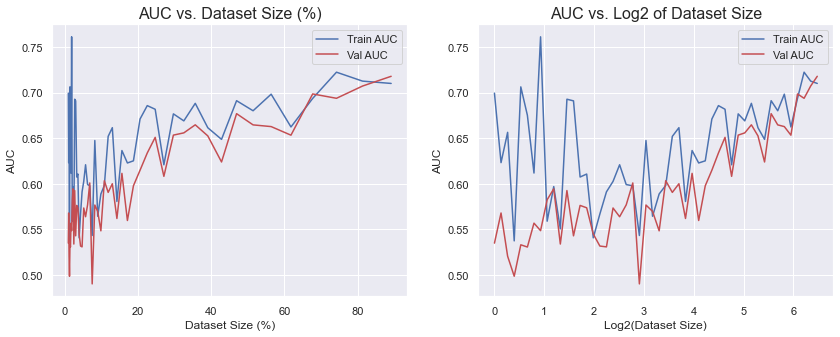

In [193]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 10
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        data = [X_train1, X_test1, y_train1, y_test1]
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        net, aucs = training_loop(50, 0.0003, *data, use_early_stopping=True)
        auc, acc = evaluate(net, X_test=X_test1, y_test=y_test1)
        avg_score_val += auc
        auc, acc = evaluate(net, X_test=X_train1, y_test=y_train1)
        avg_score_tr += auc
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    print(avg_score_tr, avg_score_val)
    scores_val.append(avg_score_val)

f, ax = plt.subplots(1,2, figsize=(14, 5))


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

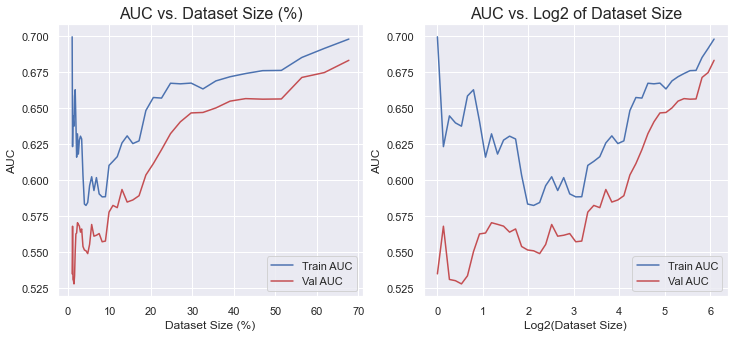

In [198]:
def compute_moving_averages(x, y1, y2):
    x_ma = x[:-3]
    y1_ma = y1[0:2]
    y2_ma = y2[0:2]
    for i in range(2, len(x)-3):
        y1_ma.append(sum(y1[i-2:i+3])/5)
        y2_ma.append(sum(y2[i-2:i+3])/5)
    return x_ma, y1_ma, y2_ma

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax[0].plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax[0].legend()
ax[0].set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax[0].set(xlabel='Dataset Size (%)', ylabel='AUC')

ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_tr_ma, '-', color="b", label="Train AUC")
ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_val_ma, '-', color="r", label="Val AUC")
ax[1].legend()
ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')

In [363]:
# Finding final train and test scores
data = [X_train, X_test, y_train, y_test]
net, aucs = training_loop(50, 0.0003, *data, use_early_stopping=True)
trn_auc, acc = evaluate(net, X_test=X_train, y_test=y_train)
tst_auc, acc = evaluate(net, X_test=X_test, y_test=y_test)
print("Train: ", trn_auc)
print("Test: ", tst_auc)

3it [00:00, 28.11it/s]

# of positive examples: 417, # of negative examples: 401


56it [00:01, 30.22it/s]

Train:  0.8302249072155293
Test:  0.8565656565656565


### 1.3 Boosting

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_tr.shape)

In [152]:
from sklearn import ensemble
from sklearn import datasets

n_folds = 5
n_loops = 3
n_estimators2 = range(1, 200, 5)
skf = StratifiedKFold(n_splits=n_folds)
avg_auc_trs_2 = []
avg_auc_vals_2 = []

for n in tqdm(n_estimators2):
    avg_auc_tr = 0
    avg_auc_val = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            
            original_params = {'n_estimators': n, 'max_depth': 2, 'random_state': 2,
                           'loss': 'exponential'}
            params = dict(original_params)
            clf = ensemble.GradientBoostingClassifier(**params)
            clf.fit(X_tr, y_tr)
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)
            avg_auc_tr += roc_auc_score(y_tr, y_pred_tr)
            avg_auc_val += roc_auc_score(y_val, y_pred_val)
    avg_auc_tr /= (n_loops*n_folds)
    avg_auc_val /= (n_loops*n_folds)
    avg_auc_trs_2.append(avg_auc_tr)
    avg_auc_vals_2.append(avg_auc_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.23s/it]


In [154]:
n_estimators4 = range(1, 100, 5)
skf = StratifiedKFold(n_splits=n_folds)
avg_auc_trs_4 = []
avg_auc_vals_4 = []

for n in tqdm(n_estimators4):
    avg_auc_tr = 0
    avg_auc_val = 0
    for i in range(n_loops):
        for train_index, test_index in skf.split(X_train, y_train):
            X_tr, X_val = X[train_index], X[test_index]
            y_tr, y_val = y[train_index], y[test_index]
            
            original_params = {'n_estimators': n, 'max_depth': 4, 'random_state': 2,
                           'loss': 'exponential'}
            params = dict(original_params)
            clf = ensemble.GradientBoostingClassifier(**params)
            clf.fit(X_tr, y_tr)
            y_pred_tr = clf.predict(X_tr)
            y_pred_val = clf.predict(X_val)
            avg_auc_tr += roc_auc_score(y_tr, y_pred_tr)
            avg_auc_val += roc_auc_score(y_val, y_pred_val)
    avg_auc_tr /= (n_loops*n_folds)
    avg_auc_val /= (n_loops*n_folds)
    avg_auc_trs_4.append(avg_auc_tr)
    avg_auc_vals_4.append(avg_auc_val)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.14s/it]


[Text(0.5, 0, 'Boosting Iterations'), Text(0, 0.5, 'AUC')]

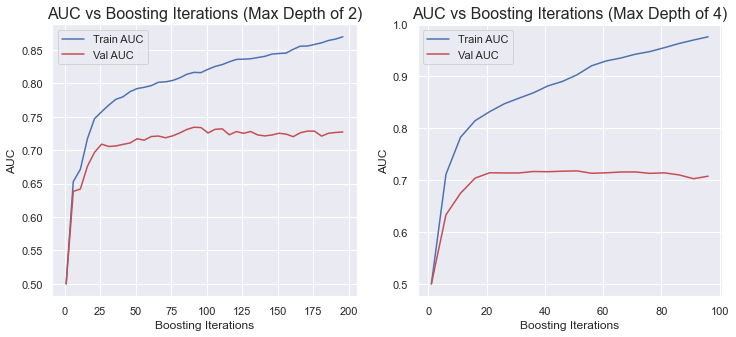

In [155]:
f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(n_estimators2, avg_auc_trs_2,'-',color="b", label="Train AUC")
ax[0].plot(n_estimators2, avg_auc_vals_2,'-',color="r", label="Val AUC")
ax[0].legend(loc='upper left')
ax[0].set_title("AUC vs Boosting Iterations (Max Depth of 2)", fontsize=16)
ax[0].set(xlabel='Boosting Iterations', ylabel='AUC')

ax[1].plot(n_estimators4, avg_auc_trs_4,'-',color="b", label="Train AUC")
ax[1].plot(n_estimators4, avg_auc_vals_4,'-',color="r", label="Val AUC")
ax[1].legend(loc='upper left')
ax[1].set_title("AUC vs Boosting Iterations (Max Depth of 4)", fontsize=16)
ax[1].set(xlabel='Boosting Iterations', ylabel='AUC')

1.0 0.5488241159716924
1.0 0.6028368050963065
1.0 0.6001751807495439
1.0 0.5784210141455972
1.0 0.5654291466776995
1.0 0.6036777894778604
1.0 0.6014348817293927
1.0 0.5932132415550566
1.0 0.5734563125475709
1.0 0.5999105407756278
1.0 0.6093487398415977
1.0 0.6137664301661556
1.0 0.57642557783612
1.0 0.6281802459052577
1.0 0.5964069678589053
1.0 0.6222001011438187
1.0 0.6378859850924684
1.0 0.648407132054661
1.0 0.6303441184462977
1.0 0.6287153607200822
1.0 0.6307131985777017
1.0 0.6483938655759093
1.0 0.6390097834259331
1.0 0.6573219877909703
1.0 0.6581583658361614
1.0 0.6663781872201128
1.0 0.6701078468204872
0.9979166666666668 0.66245735991205
0.9964102564102564 0.6567354247161525
0.9915411922681905 0.6664965994670224
0.9893592265394269 0.6776725848038774
0.9812169863481073 0.6742028871442568
0.975868741966303 0.6807964027569341
0.957461279877179 0.68368844026463
0.9651485578855636 0.6708191511117311
0.9414612177343507 0.684356714734587
0.9409191683456924 0.694454698933877
0.92047352

[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

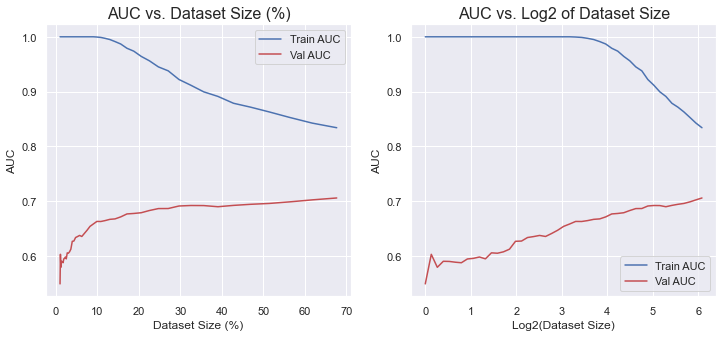

In [202]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
n = 10
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        data = [X_train1, X_test1, y_train1, y_test1]
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        original_params = {'n_estimators': 100, 'max_depth': 2, 'random_state': 2,
                       'loss': 'exponential'}
        params = dict(original_params)
        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
    scores_val.append(avg_score_val)

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax[0].plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax[0].legend()
ax[0].set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax[0].set(xlabel='Dataset Size (%)', ylabel='AUC')

ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_tr_ma, '-', color="b", label="Train AUC")
ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_val_ma, '-', color="r", label="Val AUC")
ax[1].legend()
ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')

In [352]:
# Finding final train and test scores
clf = ensemble.GradientBoostingClassifier(n_estimators= 100,max_depth=2, random_state=2,loss='exponential')
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Test:  0.7383838383838384
Train:  0.8029691030639364


### 1.4 Support Vector Machines

#### Deciding on a kernel..

In [355]:
from sklearn import svm
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds)


for kernel in ['rbf', 'poly', 'sigmoid']:
    auc_avg = 0
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X[train_index], X[test_index]
        y_tr, y_val = y[train_index], y[test_index]
        clf = svm.SVC(kernel=kernel) # class_weight={0:1, 1:1}
        clf.fit(X_tr, y_tr)
#         print(clf.support_vectors_)
#         print(clf.n_support_)
        y_pred = clf.predict(X_val)
        auc = roc_auc_score(y_val, np.round(y_pred).astype(np.int32))
        auc_avg += auc
#         print("Kernel: {}, Score: {}".format(kernel, auc)) 
    auc_avg /= n_folds
    print("Kernel: {}, Score: {}".format(kernel, auc_avg)) 


Kernel: rbf, Score: 0.6962532748049811
Kernel: poly, Score: 0.680607311982413
Kernel: sigmoid, Score: 0.39563713018897095


In [356]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
from math import log10, floor

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Comparing different values of C and gamma
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
# metric options: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

C_range = [round_sig(el) for el in np.logspace(-9, 5, 8)]
gamma_range = [round_sig(el) for el in np.logspace(-12, 2, 8)]
print(C_range, gamma_range)
# C_range = [1]
# gamma_range = [0.01]
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=43)
grid = GridSearchCV(svm.SVC(kernel='rbf', class_weight={0:1, 1:1}), param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
grid.cv_results_['mean_test_score']

[1e-09, 1e-07, 1e-05, 0.001, 0.1, 10.0, 1000.0, 100000.0] [1e-12, 1e-10, 1e-08, 1e-06, 0.0001, 0.01, 1.0, 100.0]
The best parameters are {'C': 1000.0, 'gamma': 0.0001} with a score of 0.82


array([0.5       , 0.61706395, 0.80866279, 0.80252907, 0.80773256,
       0.81238372, 0.73726744, 0.49610465, 0.61706395, 0.79781977,
       0.80860465, 0.80372093, 0.80796512, 0.81238372, 0.73726744,
       0.49276163, 0.79793605, 0.7980814 , 0.80872093, 0.80418605,
       0.80796512, 0.81238372, 0.73726744, 0.49627907, 0.79811047,
       0.7980814 , 0.80860465, 0.80563953, 0.80796512, 0.81209302,
       0.73261628, 0.50985465, 0.7980814 , 0.7980814 , 0.80901163,
       0.80505814, 0.81337209, 0.81552326, 0.75348837, 0.52872093,
       0.7980814 , 0.7980814 , 0.81052326, 0.81517442, 0.81703488,
       0.81151163, 0.72656977, 0.5402907 , 0.79802326, 0.7980814 ,
       0.81581395, 0.81703488, 0.8194186 , 0.78953488, 0.71715116,
       0.5402907 , 0.7980814 , 0.7980814 , 0.81575581, 0.81906977,
       0.81069767, 0.6919186 , 0.71715116, 0.5402907 ])

[[0.5        0.61706395 0.80866279 0.80252907 0.80773256 0.81238372
  0.73726744 0.49610465]
 [0.61706395 0.79781977 0.80860465 0.80372093 0.80796512 0.81238372
  0.73726744 0.49276163]
 [0.79793605 0.7980814  0.80872093 0.80418605 0.80796512 0.81238372
  0.73726744 0.49627907]
 [0.79811047 0.7980814  0.80860465 0.80563953 0.80796512 0.81209302
  0.73261628 0.50985465]
 [0.7980814  0.7980814  0.80901163 0.80505814 0.81337209 0.81552326
  0.75348837 0.52872093]
 [0.7980814  0.7980814  0.81052326 0.81517442 0.81703488 0.81151163
  0.72656977 0.5402907 ]
 [0.79802326 0.7980814  0.81581395 0.81703488 0.8194186  0.78953488
  0.71715116 0.5402907 ]
 [0.7980814  0.7980814  0.81575581 0.81906977 0.81069767 0.6919186
  0.71715116 0.5402907 ]]


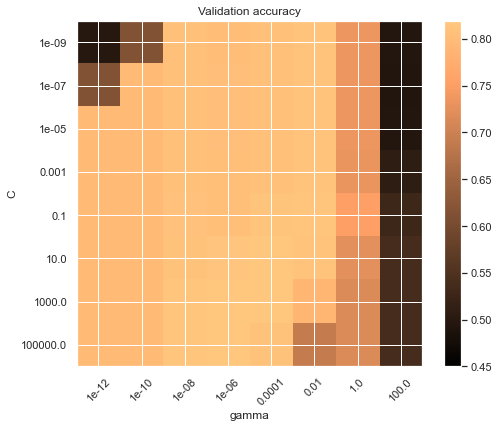

In [357]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
print(scores)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.copper,
           norm=MidpointNormalize(vmin=0.45, midpoint=0.65))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

[0.01       0.01095963 0.01201135 0.013164   0.01442725 0.01581174
 0.01732908 0.01899203 0.02081457 0.02281199 0.0250011  0.02740029
 0.0300297  0.03291144 0.03606973 0.03953109 0.04332461 0.04748218
 0.05203871 0.05703251 0.06250552 0.06850374 0.07507757 0.08228224
 0.0901783  0.09883209 0.10831632 0.11871068 0.13010252 0.14258756
 0.1562707  0.17126691 0.18770221 0.20571469 0.2254557  0.24709112
 0.27080274 0.29678981 0.32527067 0.35648464 0.39069399 0.42818619
 0.46927625 0.51430943 0.56366414 0.61775508 0.67703675 0.74200727
 0.81321257 0.89125094]
3.0 210.0
1.0 212.0
2.0 211.0
2.0 211.0
2.0 211.0
2.0 211.0
1.0 212.0
0.0 213.0
0.0 213.0
1.0 212.0
4.0 209.0
3.0 210.0
3.0 210.0
2.0 211.0
3.0 210.0
1.0 212.0
4.0 209.0
0.0 213.0
2.0 211.0
1.0 212.0
4.0 209.0
1.0 212.0
5.0 208.0
1.0 212.0
3.0 210.0
1.0 212.0
2.0 211.0
2.0 211.0
3.0 210.0
3.0 210.0
3.0 210.0
2.0 211.0
4.0 209.0
4.0 209.0
2.0 211.0
1.0 212.0
2.0 211.0
6.0 207.0
3.0 210.0
5.0 208.0
3.0 210.0
3.0 210.0
2.0 211.0
3.0 210.0


[Text(0.5, 0, 'Log2(Dataset Size)'), Text(0, 0.5, 'AUC')]

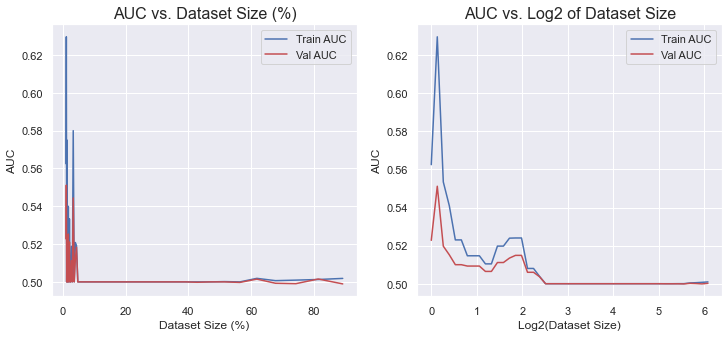

In [361]:
train_szs = np.logspace(-2, -0.05, 50) #np.linspace(0.01, 0.9, 50)
print(train_szs)
n = 10
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        print(y_train1.sum(),y_test1.sum())
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        clf = svm.SVC(kernel='rbf', C=100000, gamma=1e-8)
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
#     print(avg_score_tr, avg_score_val)
    scores_val.append(avg_score_val)
print(scores_val)

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(1,2,figsize=(12, 5))
ax[0].plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax[0].plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax[0].legend()
ax[0].set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax[0].set(xlabel='Dataset Size (%)', ylabel='AUC')

ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_tr_ma, '-', color="b", label="Train AUC")
ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_val_ma, '-', color="r", label="Val AUC")
ax[1].legend()
ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')

In [370]:
# Finding final train and test scores
clf = svm.SVC(kernel='rbf', C=1000, gamma=1e-3)
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Test:  0.7444444444444445
Train:  0.7253579665858826


### 1.5 K Nearest Neighbors

In [310]:
import sklearn
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

p_range = [1,2,3]
k_range = [1,2,5,10,20,40,80,300]
param_grid = dict(n_neighbors=k_range, p=p_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=43)
grid = GridSearchCV(sklearn.neighbors.KNeighborsClassifier(), param_grid=param_grid, cv=cv, scoring='roc_auc')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))
grid.cv_results_['mean_test_score']

The best parameters are {'n_neighbors': 40, 'p': 1} with a score of 0.81


array([0.65956395, 0.65116279, 0.63991279, 0.68901163, 0.69697674,
       0.68497093, 0.75168605, 0.74703488, 0.75116279, 0.78090116,
       0.78174419, 0.76700581, 0.79985465, 0.78020349, 0.77761628,
       0.81046512, 0.78892442, 0.78069767, 0.80177326, 0.7830814 ,
       0.78093023, 0.79482558, 0.78770349, 0.77883721])

[[0.65956395 0.68901163 0.75168605 0.78090116 0.79985465 0.81046512
  0.80177326 0.79482558]
 [0.65116279 0.69697674 0.74703488 0.78174419 0.78020349 0.78892442
  0.7830814  0.78770349]
 [0.63991279 0.68497093 0.75116279 0.76700581 0.77761628 0.78069767
  0.78093023 0.77883721]]


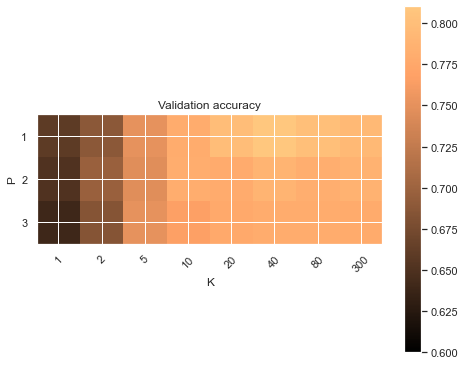

In [322]:
scores = grid.cv_results_['mean_test_score'].reshape(len(k_range),
                                                     len(p_range))
scores = np.transpose(scores)
print(scores)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.copper,
           norm=MidpointNormalize(vmin=0.60, midpoint=0.7))
plt.xlabel('K')
plt.ylabel('P')
plt.colorbar()
plt.xticks(np.arange(len(k_range)), k_range, rotation=45)
plt.yticks(np.arange(len(p_range)), p_range)
plt.title('Validation accuracy')
plt.show()

[0.1        0.10456534 0.1093391  0.11433081 0.1195504  0.12500828
 0.13071533 0.13668293 0.14292297 0.14944789 0.1562707  0.16340499
 0.17086498 0.17866555 0.18682224 0.19535131 0.20426976 0.21359537
 0.22334673 0.23354326 0.24420531 0.25535411 0.2670119  0.2792019
 0.29194842 0.30527685 0.31921378 0.33378698 0.34902549 0.36495969
 0.38162134 0.39904365 0.41726135 0.43631075 0.45622983 0.47705827
 0.4988376  0.52161124 0.54542456 0.57032505 0.59636233 0.6235883
 0.65205723 0.68182586 0.71295353 0.74550229 0.779537   0.81512552
 0.85233877 0.89125094]
20.0 193.0
0.5
22.0 191.0
0.5
28.0 185.0
0.5107961222091657
21.0 192.0
0.5
24.0 189.0
0.5
21.0 192.0
0.5
25.0 188.0
0.5
24.0 189.0
0.5052910052910053
19.0 194.0
0.5
26.0 187.0
0.5305441103416032
20.0 193.0
0.5
27.0 186.0
0.5589034621292686
21.0 192.0
0.5
25.0 188.0
0.5039379334665569
20.0 193.0
0.5
24.0 189.0
0.5
29.0 184.0
0.5841054882394868
29.0 184.0
0.5800219767165598
18.0 195.0
0.5
24.0 189.0
0.5
20.0 193.0
0.5
21.0 192.0
0.5
23.0 19

86.0 127.0
0.6074922452875209
96.0 117.0
0.6268751994893074
99.0 114.0
0.6324058096059821
89.0 124.0
0.5720981527433141
81.0 132.0
0.5577567712523466
92.0 121.0
0.6422877203247276
94.0 119.0
0.632610939112487
90.0 123.0
0.6351807491289199
94.0 119.0
0.5896911396137402
96.0 117.0
0.6151616499442587
97.0 116.0
0.6120316465144052
85.0 128.0
0.5950164098173516
102.0 111.0
0.6510535959688503
93.0 120.0
0.6233296622613803
92.0 121.0
0.6275140788415124
81.0 132.0
0.5442919291929192
88.0 125.0
0.6128995215311005
102.0 111.0
0.6442653415747586
102.0 111.0
0.6218236173393124
101.0 112.0
0.6492921492921494
98.0 115.0
0.6440142942227516
93.0 120.0
0.6211448598130841
85.0 128.0
0.6031553398058253
88.0 125.0
0.5560382775119618
108.0 105.0
0.6948222083593263
113.0 100.0
0.6669369369369369
102.0 111.0
0.6531745015157336
98.0 115.0
0.6323671497584541
100.0 113.0
0.5700766397086845
100.0 113.0
0.5861032307236314
91.0 122.0
0.6077459016393442
98.0 115.0
0.5859903381642512
89.0 124.0
0.5276963180188986
91

[Text(0.5, 0, 'Dataset Size (%)'), Text(0, 0.5, 'AUC')]

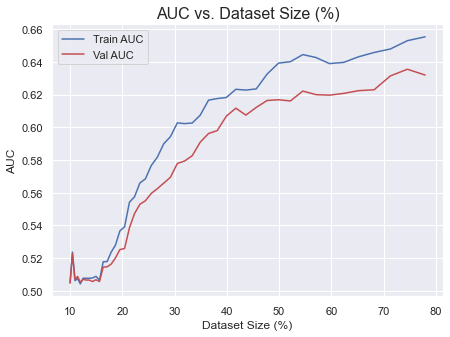

In [330]:
train_szs = np.logspace(-1, -0.05, 50) #np.linspace(0.01, 0.9, 50)
print(train_szs)
n = 10
scores_tr = []
scores_val = []
for train_sz in train_szs:
    avg_score_tr = 0
    avg_score_val = 0
    worked = 0
    for i in range(n):
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=1-train_sz)
        print(y_train1.sum(),y_test1.sum())
        if (y_train1.sum()==0) or (y_test1.sum()==0) or ((y_train1==0).sum()==0) or ((y_test1==0).sum()==0): continue
            
        clf = sklearn.neighbors.KNeighborsClassifier(p=1, n_neighbors=40)
        clf.fit(X_train1, y_train1)
        
        y_pred_tr = clf.predict(X_train1)
        y_pred_val = clf.predict(X_test1)
        print(roc_auc_score(y_test1, y_pred_val))
        avg_score_val += roc_auc_score(y_test1, y_pred_val)
        avg_score_tr += roc_auc_score(y_train1, y_pred_tr)
        
        worked += 1
    avg_score_tr /= worked
    avg_score_val /= worked
    scores_tr.append(avg_score_tr)
#     print(avg_score_tr, avg_score_val)
    scores_val.append(avg_score_val)
print(scores_val)

train_szs_ma, aucs_tr_ma, aucs_val_ma = compute_moving_averages(train_szs, scores_tr, scores_val)

f, ax = plt.subplots(1,1,figsize=(7, 5))
ax.plot(np.array(train_szs_ma)*100, aucs_tr_ma, '-', color="b", label="Train AUC")
ax.plot(np.array(train_szs_ma)*100, aucs_val_ma, '-', color="r", label="Val AUC")
ax.legend()
ax.set_title("AUC vs. Dataset Size (%)", fontsize=16)
ax.set(xlabel='Dataset Size (%)', ylabel='AUC')

# ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_tr_ma, '-', color="b", label="Train AUC")
# ax[1].plot(np.log2(np.array(train_szs_ma)*100), aucs_val_ma, '-', color="r", label="Val AUC")
# ax[1].legend()
# ax[1].set_title("AUC vs. Log2 of Dataset Size", fontsize=16)
# ax[1].set(xlabel='Log2(Dataset Size)', ylabel='AUC')

In [340]:
# Finding final train and test scores
clf = sklearn.neighbors.KNeighborsClassifier(p=1, n_neighbors=40)
clf.fit(X_train, y_train)
y_pred_tr = clf.predict(X_train)
y_pred_val = clf.predict(X_test)
print("Test: ", roc_auc_score(y_test, y_pred_val))
print("Train: ", roc_auc_score(y_train, y_pred_tr))

Test:  0.695959595959596
Train:  0.6638099586713967
